In [2]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import numpy.linalg as la
import numpy.ma as ma
import scipy.optimize as opt
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

import push_pull as pp
import noise_models as noise

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

,dataset,construct,model
0,E+E,E+E,push
1,I+E,I+E,push
2,RR+A,RR+A,push
3,S+A,S+A,push
4,S+E,S+E,push


96261 / 96261


WT_anti_exp  ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp
dataset                                                                 
E+E     0       5993.989258  6394.181152   8649.121094          1.352655
        1        484.283875   664.000793    564.378601          0.849967
        2        605.894165   737.394714     91.147232          0.123607
        3        803.416565   333.886597    168.033020          0.503264
        4       3100.157715   131.973206     60.481567          0.458287
...                     ...          ...           ...               ...
S+E     18757   1177.671265   390.252075    400.376099          1.025942
        18758   1190.564575    81.183945    158.838196          1.956522
        18759  11397.416992  1473.975220    342.042755          0.232055
        18760   1293.171875   652.249451    481.467163          0.738164
        18761    322.256653   336.612762     55.410645          0.164612

[96261 rows x 4 columns]

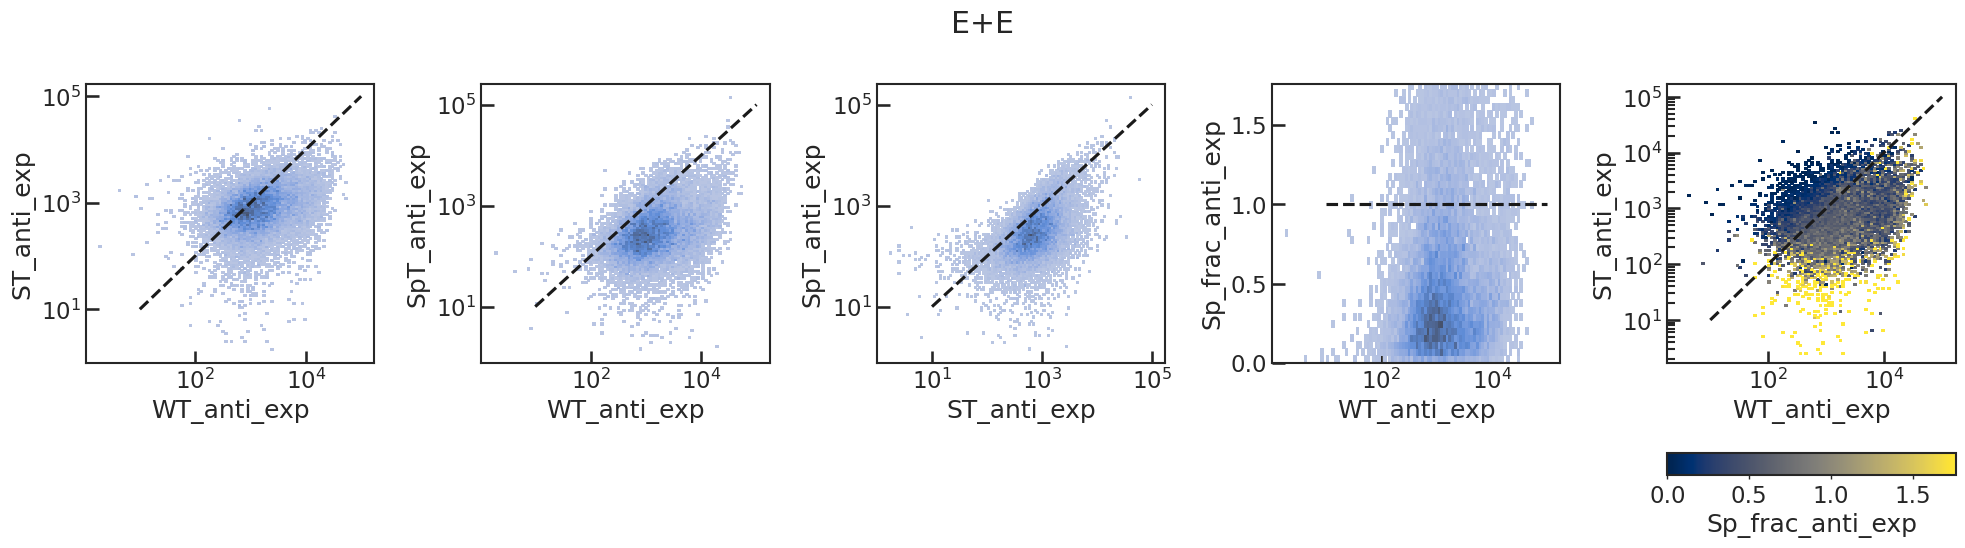

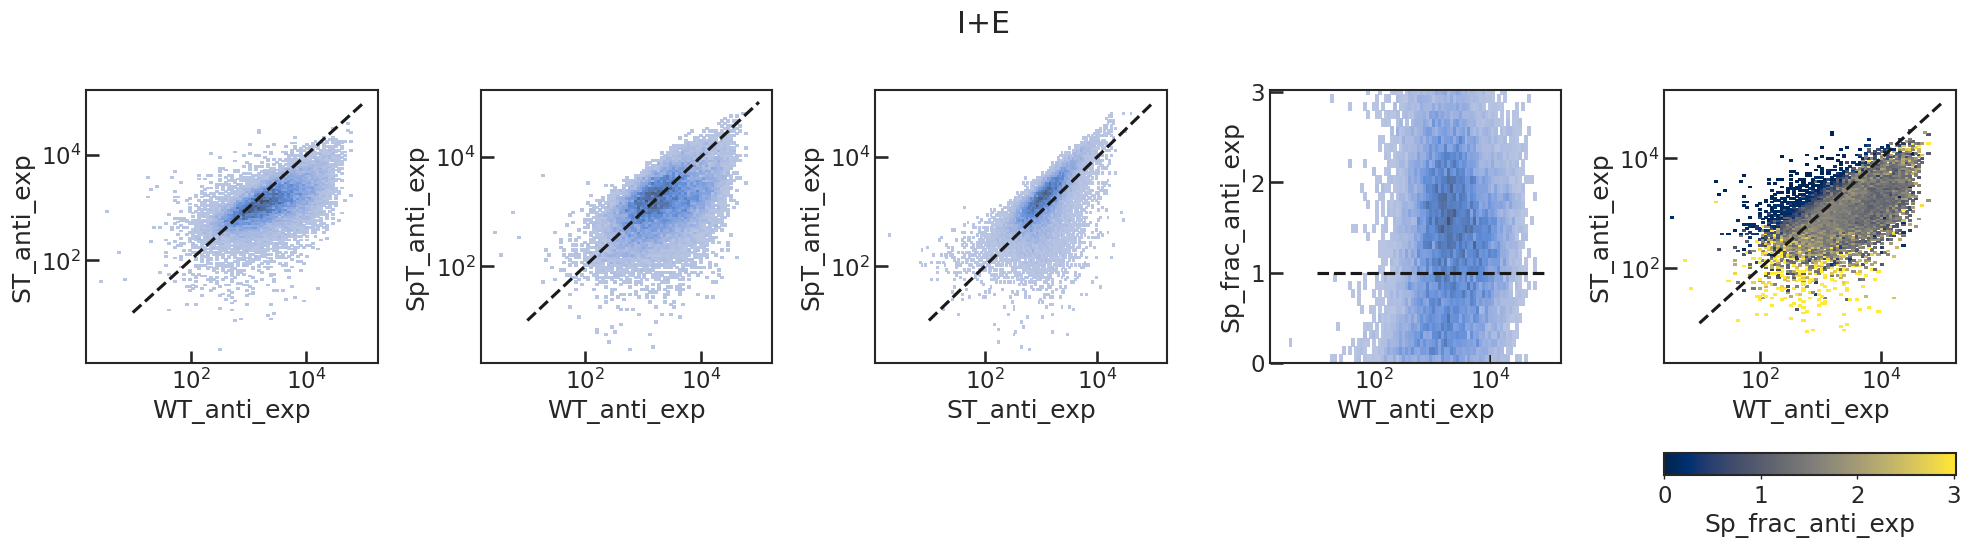

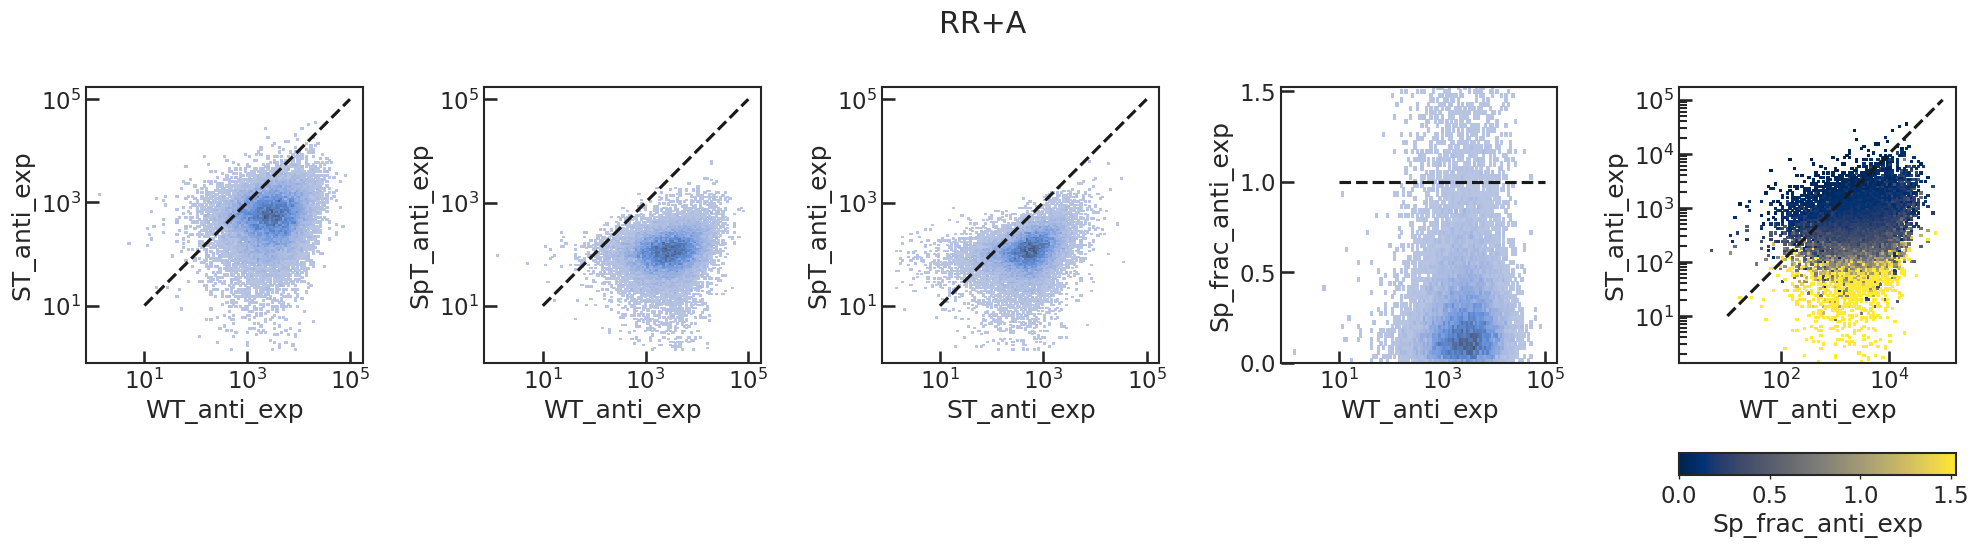

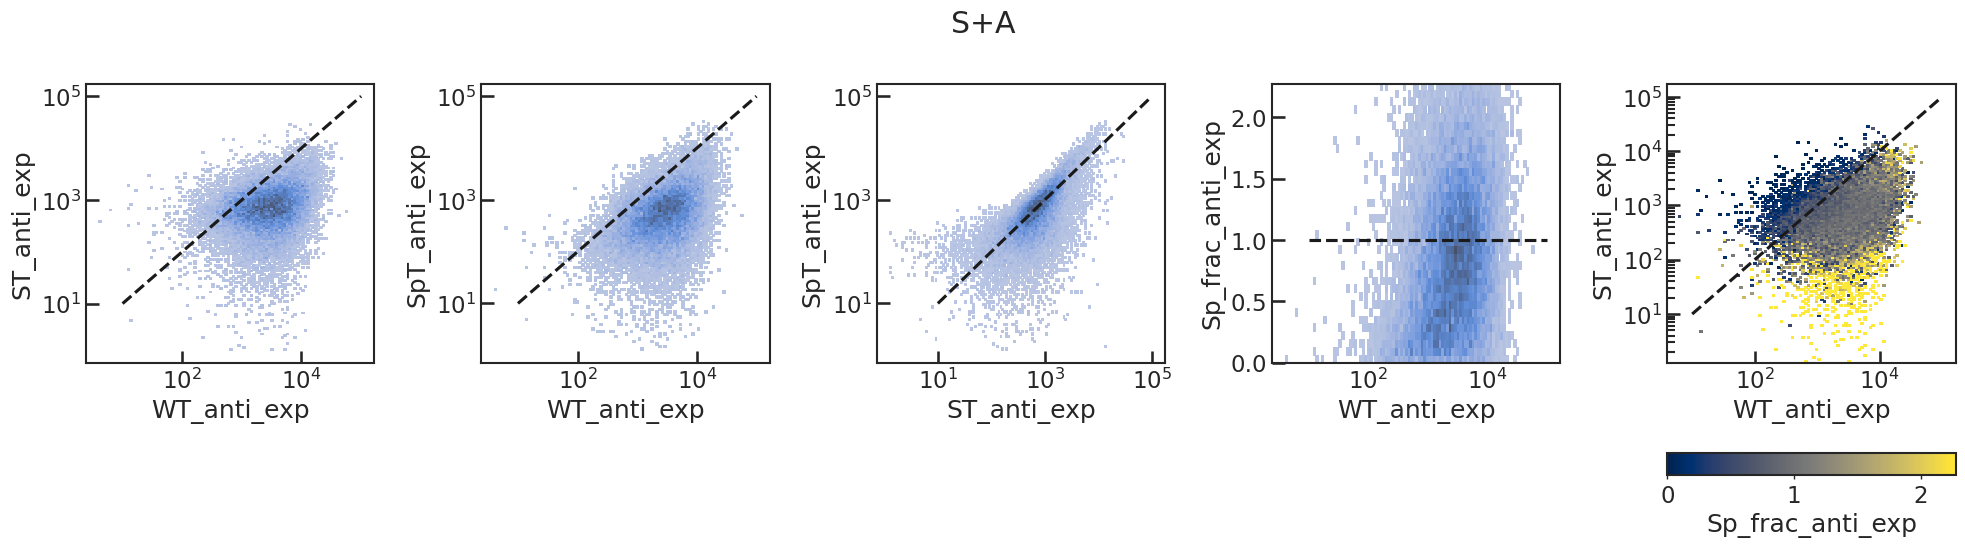

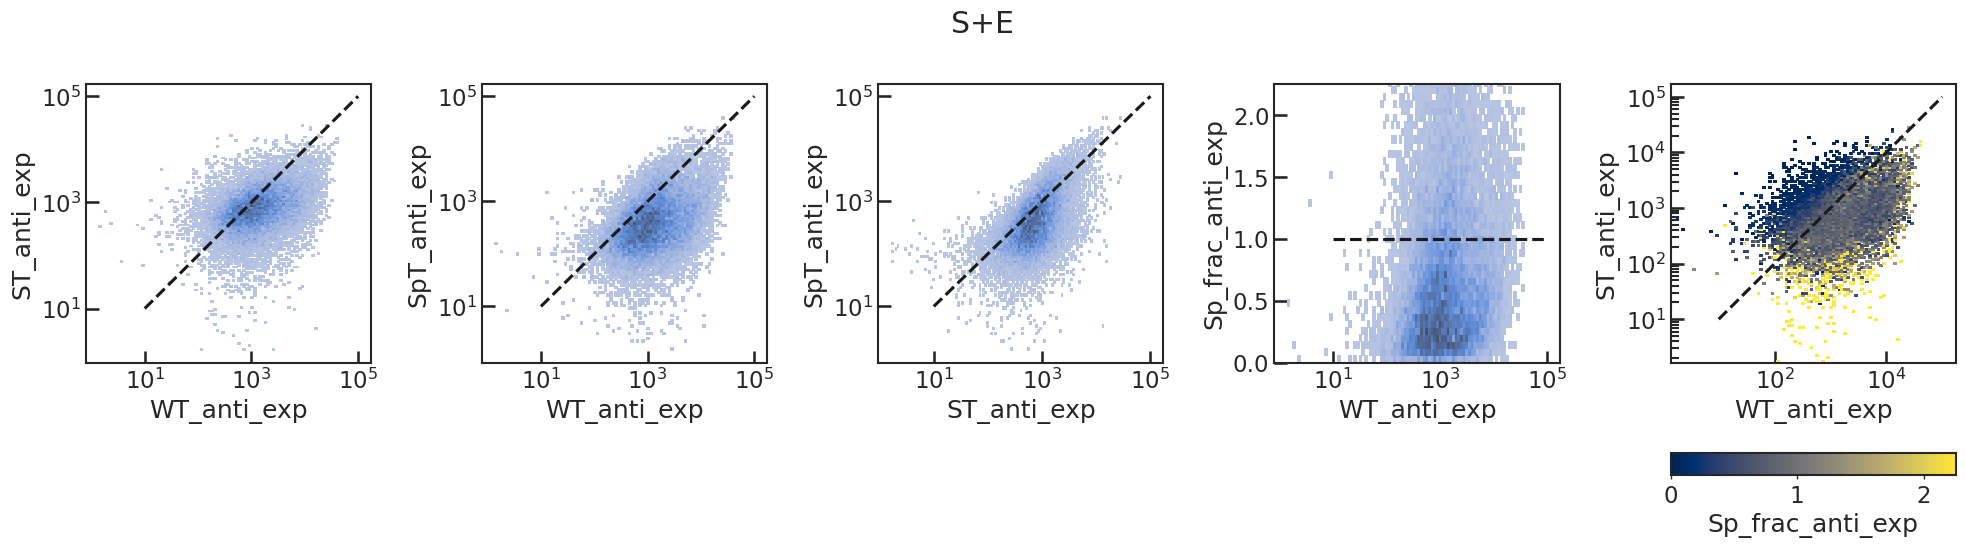

In [208]:


# dataset, construct, model
s_list = [
    ['E+E', 'E+E', 'push'],
    ['I+E', 'I+E', 'push'],
    ['RR+A', 'RR+A', 'push'],
    ['S+A', 'S+A', 'push'],
    ['S+E', 'S+E', 'push']
         ]

df_info = pd.DataFrame(s_list, columns=['dataset', 'construct', 'model'])
     
display(df_info)

df_list = []
for index, row in df_info.iterrows():
    df = pd.read_csv("../data/push_data/Zipper Variant/{}.csv".format(row['dataset']))    
    df['dataset'] = row['dataset']    
    df_list.append(df)
    
    
df = pd.concat(df_list).drop("Unnamed: 0", axis=1, errors='ignore')


df.set_index("dataset", inplace=True, append=True)
df = df.reorder_levels(df.index.names[::-1])


df = df[(df[df.columns[:-1]] > 0).all(axis=1)].rename(columns={'WT_anti': 'WT_anti_exp', 'ST_anti': 'ST_anti_exp', 'SpT_anti': 'SpT_anti_exp'})

df['Sp_frac_anti_exp'] = df['SpT_anti_exp'] / df['ST_anti_exp']


print(len(df.index), "/", len(df.index))

display(df)


for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4.5))

    
    fig.suptitle(construct)
    
    ax = axes[0]
    
    sns.histplot(group, x='WT_anti_exp', y='ST_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax = axes[1]
    
    sns.histplot(group, x='WT_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    
    ax = axes[2]
    
    sns.histplot(group, x='ST_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax = axes[3]
        
    
    sns.histplot(group, x='WT_anti_exp', y='Sp_frac_anti_exp', 
                 log_scale=(True, False), ax=ax)
    
    ax.hlines(1e0, xmin=1e1, xmax=1e5, color='k', ls='--')
        
    ax.set_ylim(0, group['Sp_frac_anti_exp'].quantile(0.95))
    
    
    ax = axes[4]
    
    df_tmp = group.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=group['Sp_frac_anti_exp'].quantile(0.95))
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
        
    
    
    plt.tight_layout()
    
    
    
    bbox = ax.get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")

    

    plt.show()
    
    


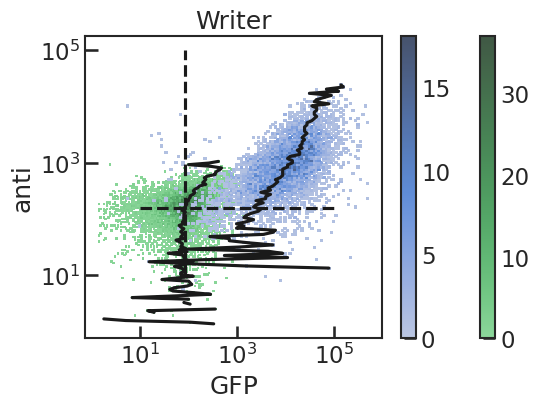

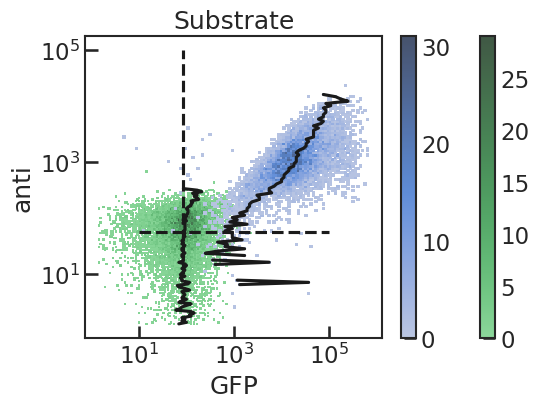

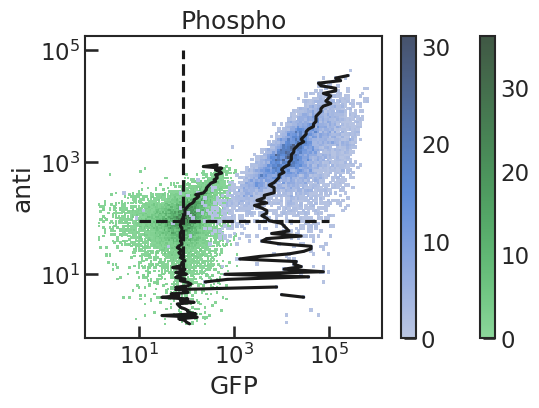

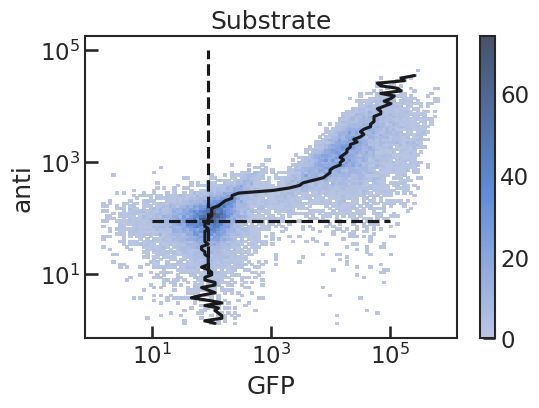

In [209]:
nbins_anti = 100
nbins_GFP = 100

writer_noise = noise.EmpiricalNoise("../data/noise_data/Flag noise.csv", 
                                   'HA', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)

empty_writer_noise = noise.EmpiricalNoise("../data/noise_data/Empty Cell.csv", 
                                   'HA', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_writer_noise.plot(ax, color='g')
writer_noise.plot(ax)

ax.set_title("Writer")

ax.hlines(10**np.mean(np.log10(empty_writer_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_writer_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()

# writer_noise.add_cells(empty_writer_noise)

# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# writer_noise.plot(ax)

# ax.set_title("Writer")

# ax.hlines(10**np.mean(np.log10(empty_writer_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

# ax.vlines(10**np.mean(np.log10(empty_writer_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


# plt.show()





    
substrate_noise = noise.EmpiricalNoise("../data/noise_data/Phopho_Myc noise.csv", 
                                   'Myc', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)

empty_substrate_noise = noise.EmpiricalNoise("../data/noise_data/Empty Cell.csv", 
                                   'Myc', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)



fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_substrate_noise.plot(ax, color='g')
substrate_noise.plot(ax)
ax.set_title("Substrate")

ax.hlines(10**np.mean(np.log10(empty_substrate_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_substrate_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()



# substrate_noise.add_cells(empty_substrate_noise)

# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# substrate_noise.plot(ax)

# ax.set_title("Substrate")

# ax.hlines(10**np.mean(np.log10(empty_substrate_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

# ax.vlines(10**np.mean(np.log10(empty_substrate_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


# plt.show()




    
phospho_noise = noise.EmpiricalNoise("../data/noise_data/Phopho_Myc noise.csv", 
                                   'Phospho', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)

empty_phospho_noise = noise.EmpiricalNoise("../data/noise_data/Empty Cell.csv", 
                                   'Phospho', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

empty_phospho_noise.plot(ax, color='g')
phospho_noise.plot(ax)
ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()






phospho_noise.add_cells(empty_phospho_noise)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
phospho_noise.plot(ax)

ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()







0.12849785204676112 [0.         0.33786815] 0
0.09325024513888525 [0.33259341 0.6953146 ] 0
0.06670589728103493 [0.11942746 0.40041797] 0
0.05685923041228347 [0.13295747 0.40041797] 0
0.04510239781571451 [0.04977486 0.29668743] 0
0.04265098791271338 [0.04843821 0.29209685] 0
0.03674993104744062 [0.04843821 0.28447741] 0
0.036697768312128454 [0.04849538 0.28447741] 0
0.03667306859633576 [0.02485377 0.23657986] 0
0.032726880488156085 [0.0179767  0.23657986] 0
0.032474878988184575 [0.01534248 0.23657986] 0
0.03232446466290195 [0.01534248 0.23697207] 0
0.03202363601233871 [0.01534248 0.23776928] 0
0.03184970433415979 [0.01354709 0.23776928] 0
0.031849704334159235 [0.01354709 0.23751214] 0
0.031797350070980945 [0.01300775 0.23751214] 0
0.03178713081622131 [0.01290254 0.23751214] 0
0.03178685341179355 [0.01289968 0.23751214] 0
0.03172744550667783 [0.01693374 0.24048635] 0
0.03172744550667772 [0.01693374 0.2404781 ] 0
0.03171489218139878 [0.01680475 0.2404781 ] 0
0.031446303832054046 [0.01712

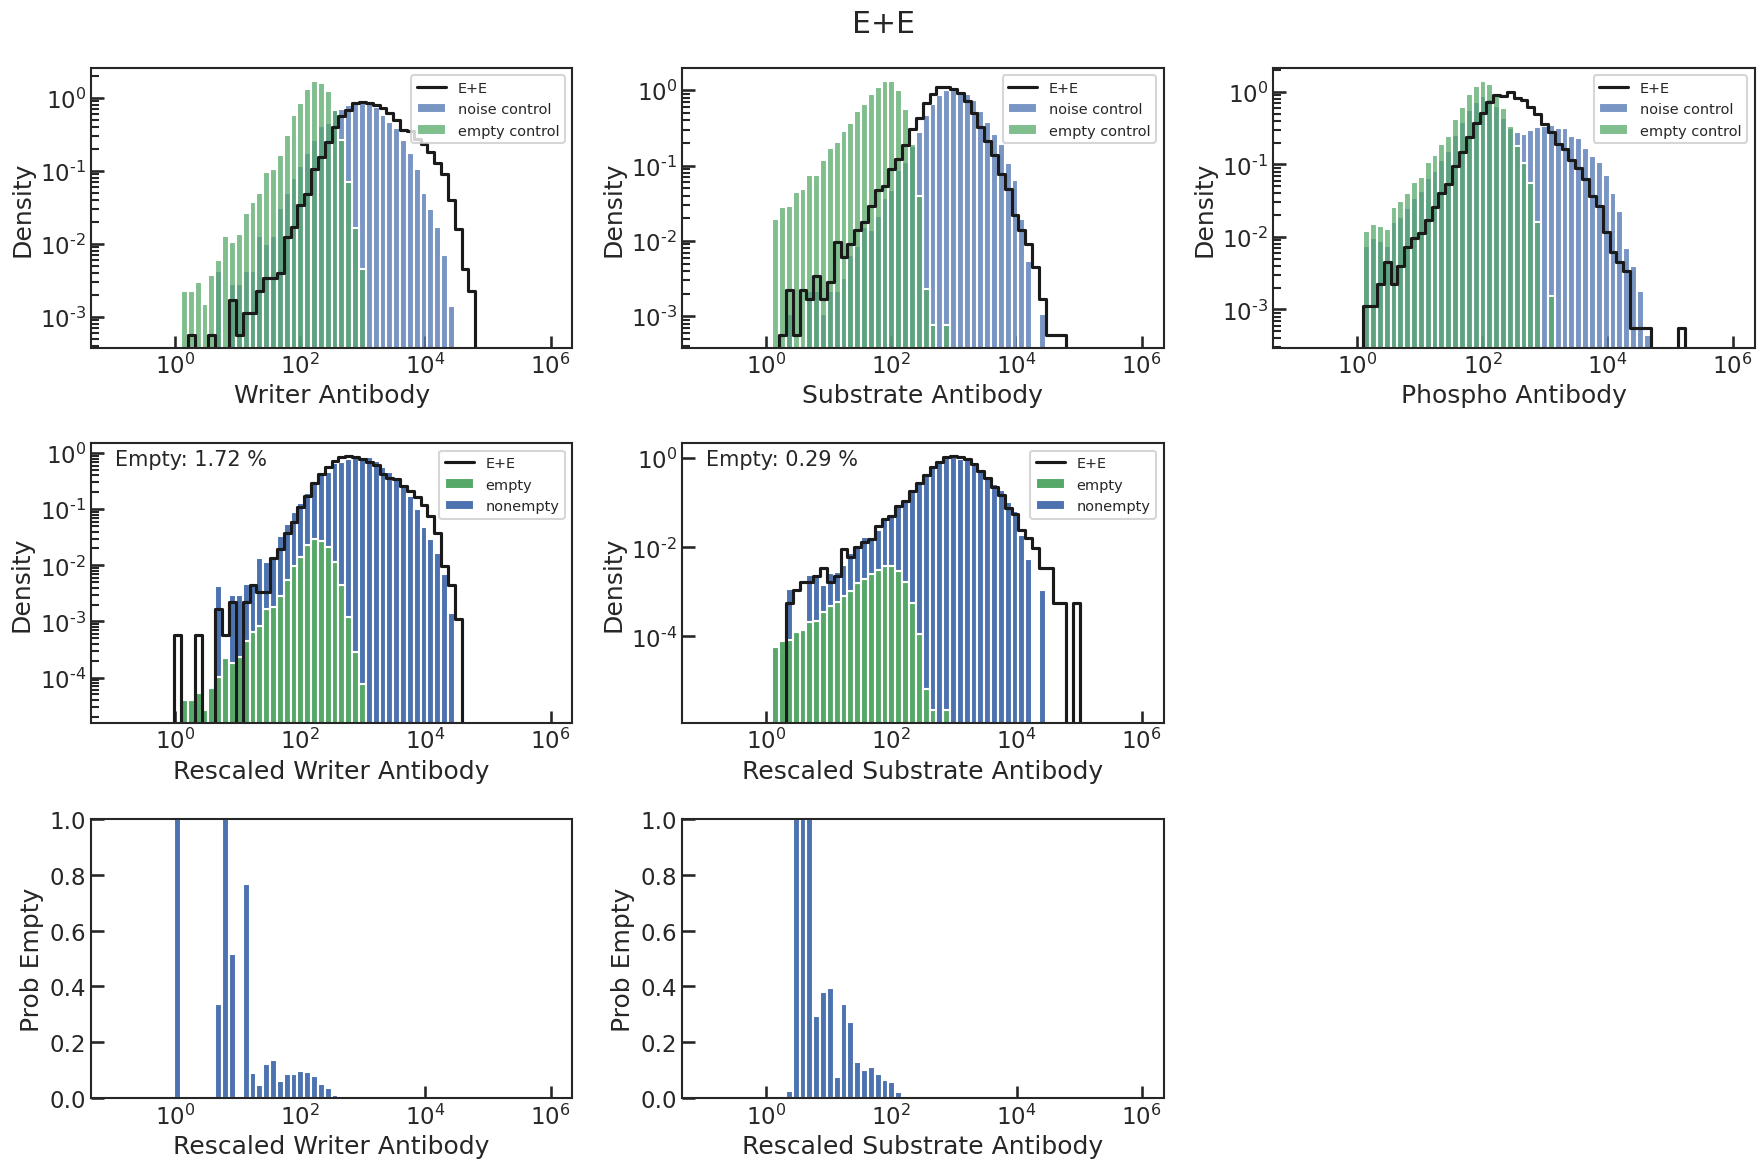

0.17770353340408174 [0.6957284  0.92985605] 0
0.16614377110862388 [0.75609702 0.99022467] 0
0.13324286804528607 [0.59483922 0.91329642] 0
0.1141354020523131 [0.56278185 0.91329642] 0
0.09870013014026735 [0.53773377 0.91329642] 0
0.05229829006009912 [0.23289693 0.71797568] 0
0.04381553110969438 [0.30710376 0.77001124] 0
0.039638284225025244 [0.02567129 0.46709754] 0
0.029204194383537108 [0.02567129 0.45231579] 0
0.027852541882878445 [0.02567129 0.43940958] 0
0.02760171266040623 [0.0247028  0.43940958] 0
0.02645087086741016 [0.02027965 0.43940958] 0
0.026315860520104595 [0.01976294 0.43940958] 0
0.026208963542430297 [0.01935414 0.43940958] 0
0.02514768824499325 [0.04390319 0.45712854] 0
0.024733046960421445 [0.04225302 0.45712854] 0
0.024733046960421334 [0.04225302 0.45710192] 0
0.024379736257905238 [0.04085053 0.45710192] 0
0.022388841210809196 [0.04085053 0.46226499] 0
0.02213710422561066 [0.04085053 0.46280676] 0
0.022074687349363353 [0.0406039  0.46280676] 0
0.021369954028862326 [0.0

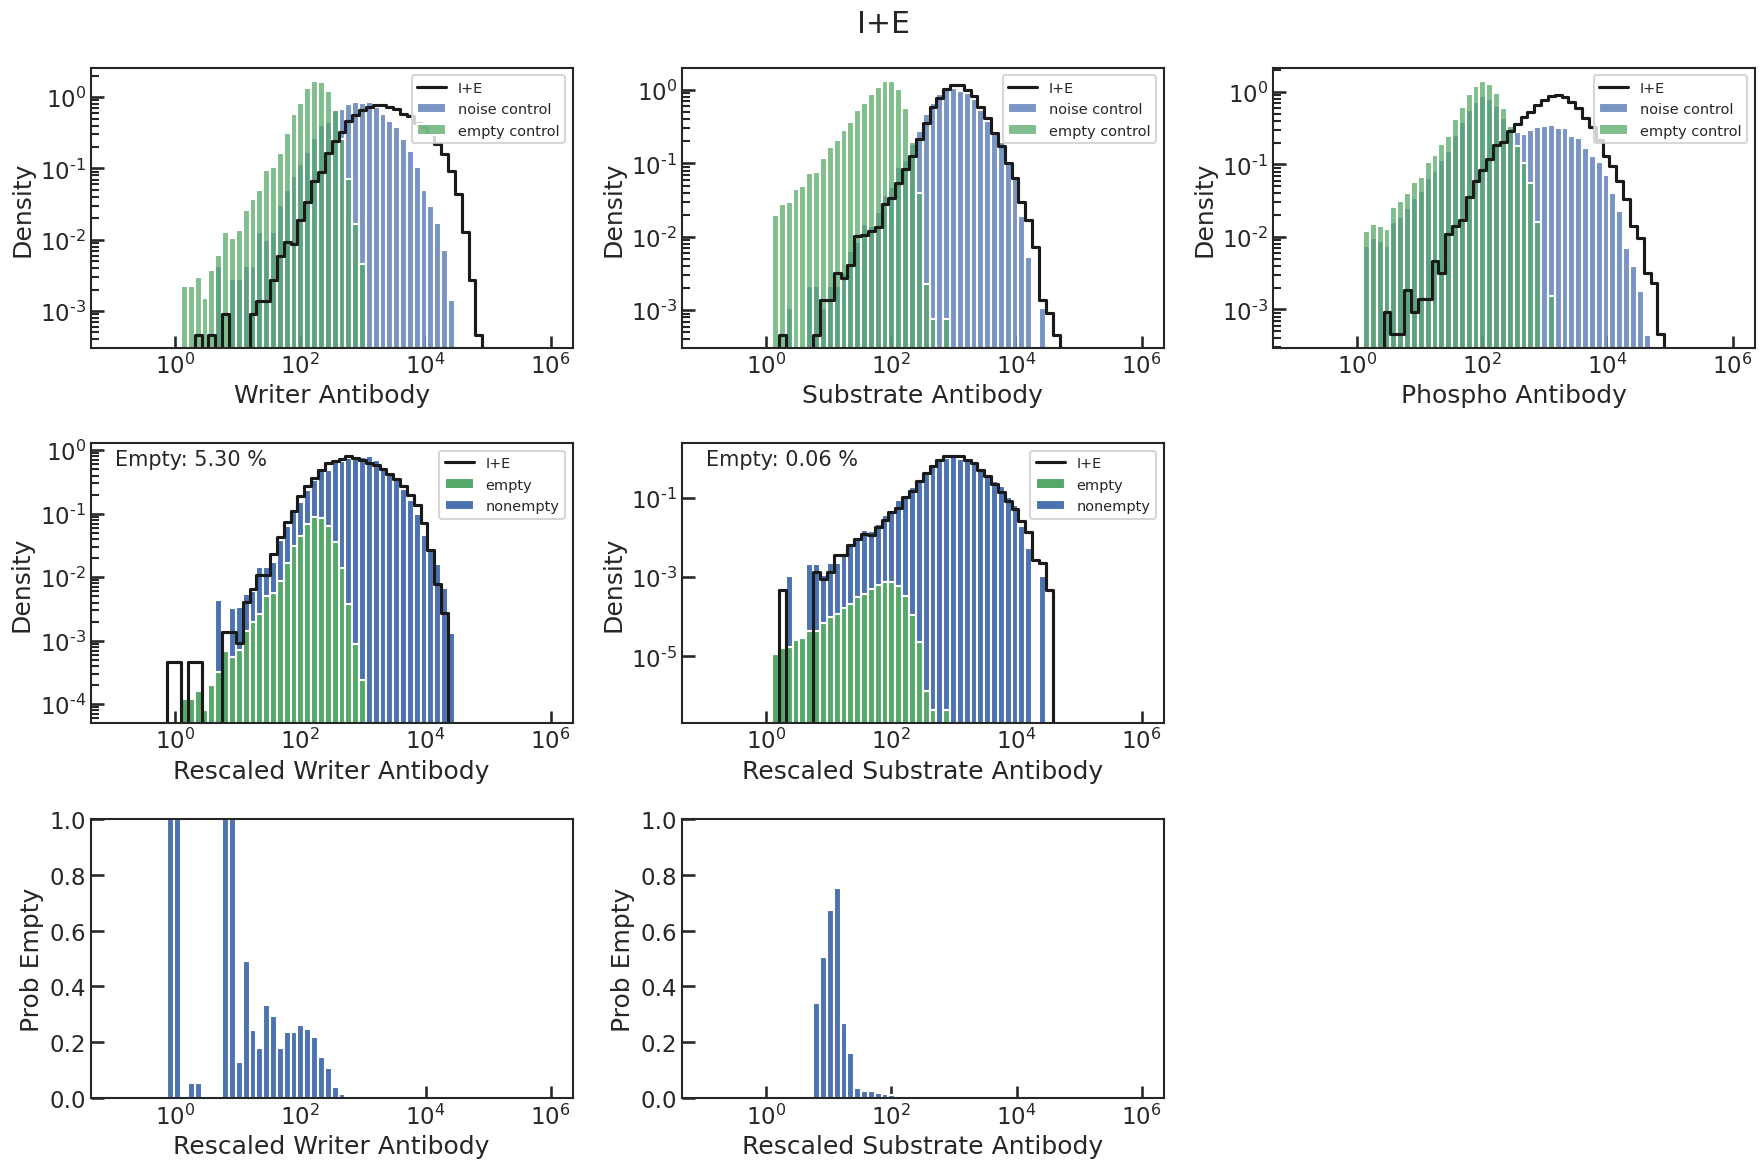

0.14670887666551535 [0.         0.34569936] 0
0.11062180282582013 [0.03498339 0.42613555] 0
0.030406279910531353 [0.03498339 0.54542458] 0
0.030406279910530687 [0.03498339 0.54538143] 0
0.030305036913844674 [0.03498339 0.54483101] 0
0.029355946277418554 [0.02516247 0.53760628] 0
0.028795065184209823 [0.02516247 0.53534647] 0
0.024760106791118258 [0.00966803 0.50374288] 0
0.023606151654643803 [0.00966803 0.50528983] 0
0.022840103326814687 [0.00966803 0.50624588] 0
0.022185304995621213 [0.00966803 0.50833037] 0
0.022033282614768113 [0.00966803 0.50760784] 0
0.01866189755228781 [0.00070864 0.49649443] 0
0.018564147400070508 [0.00070864 0.49669956] 0
0.018558021234842403 [0.00074068 0.49669956] 0
0.018546551226698238 [0.00080068 0.49669956] 0
0.018542401789933494 [0.00082239 0.49669956] 0
0.01854240178993327 [0.00082239 0.49688376] 0
0.018532676796876757 [0.00087327 0.49688376] 0
0.018530875997827545 [0.00088269 0.49688376] 0
0.018530810324380198 [0.00088303 0.49688376] 0
     fun: 0.01853

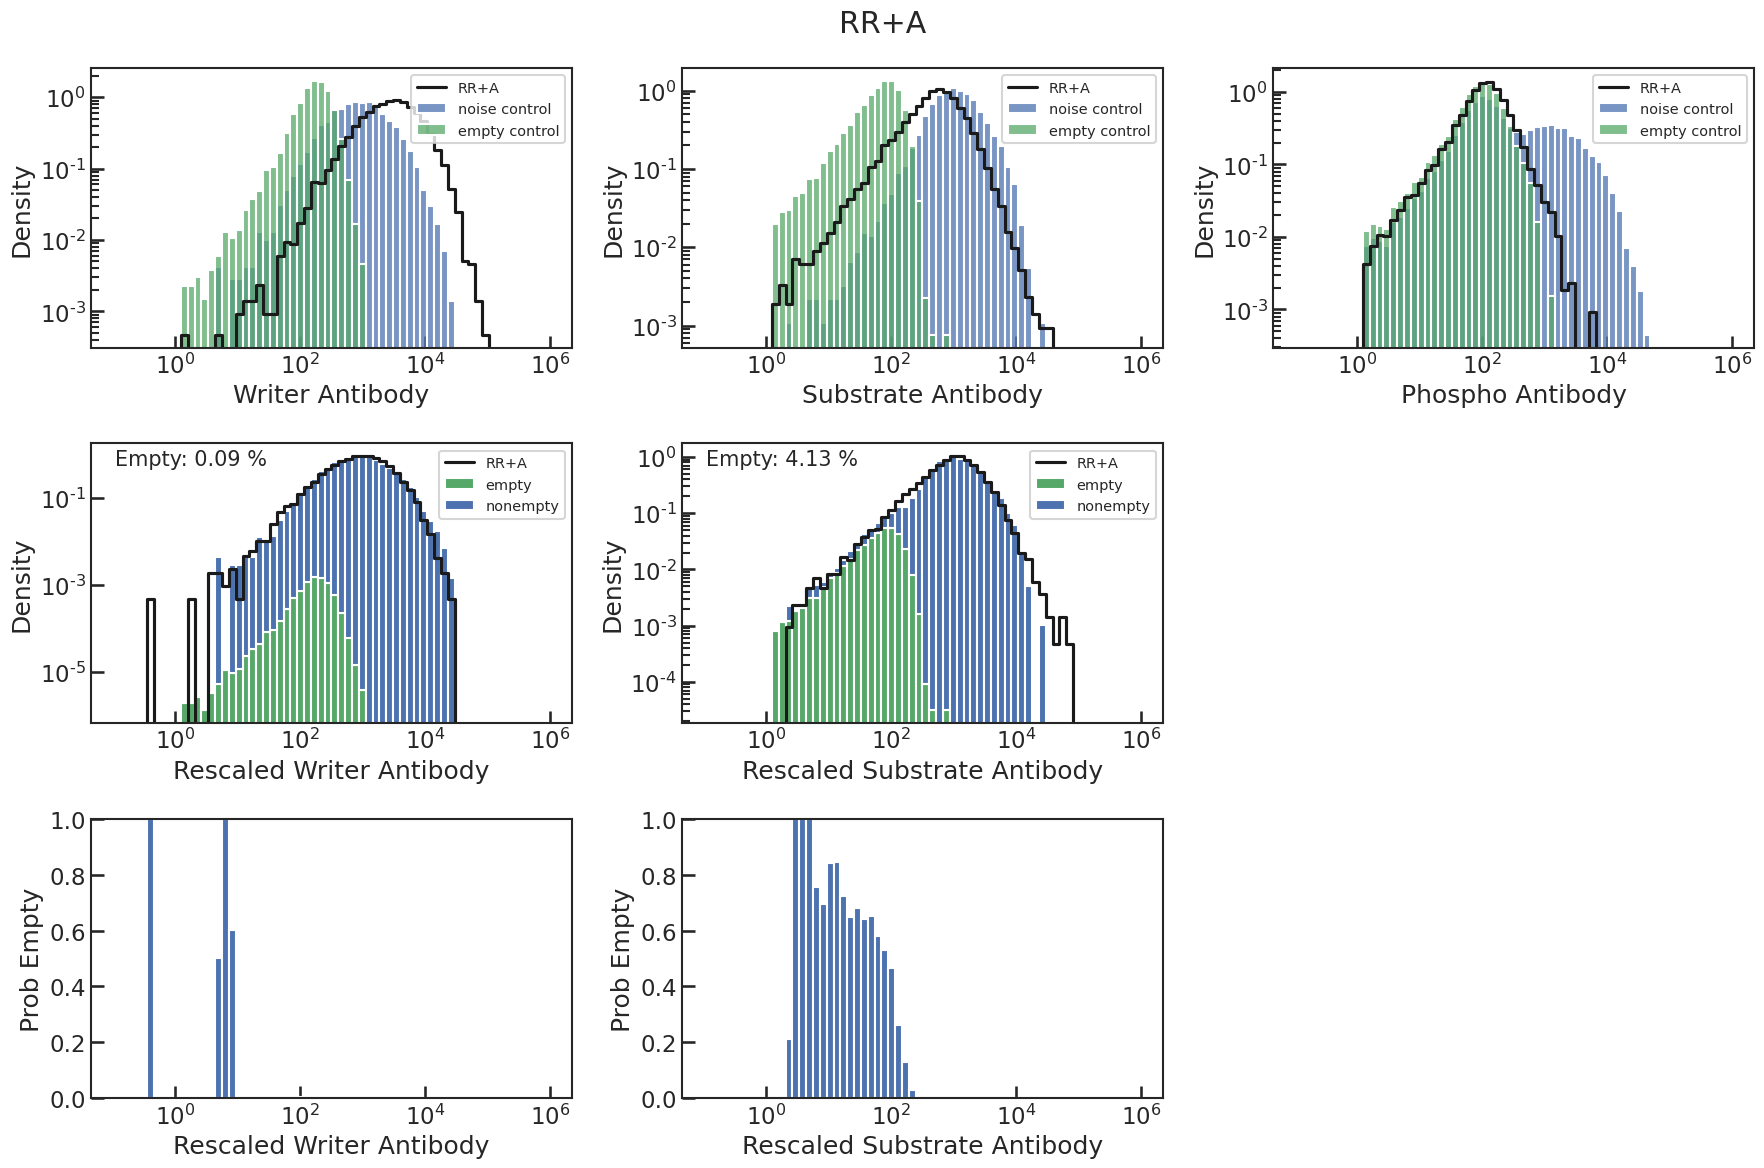

0.42694161843615874 [0.81472196 0.81472196] 0
0.3572584314921347 [0.16974444 0.25047746] 0
0.2985734750365546 [0.09175895 0.25047746] 0
0.29785762350520595 [0.09081908 0.25047746] 0
0.07684800131401548 [0.09081908 0.57768403] 0
0.050699479596976404 [0.04239209 0.57768403] 0
0.04788688861946666 [0.05752126 0.57768403] 0
0.045507480514792864 [0.05752126 0.56487241] 0
0.04494673378005887 [0.04973537 0.56487241] 0
0.044121107202831134 [0.05423026 0.56487241] 0
0.04396137471412154 [0.05423026 0.56425809] 0
0.043548454912322954 [0.05423026 0.56302964] 0
0.03896899150779476 [0.02939158 0.53876659] 0
0.0389172420048195 [0.02965977 0.53876659] 0
0.03864555199874764 [0.03106984 0.53876659] 0
0.03732481164347451 [0.0326812  0.53087575] 0
0.036951910491330064 [0.02401697 0.53087575] 0
0.03595211941762666 [0.02401697 0.51646173] 0
0.03258063764714536 [0.01342712 0.51646173] 0
0.03059855811058143 [0.01342712 0.50413212] 0
0.030398954099626896 [0.01342712 0.51068877] 0
0.02950971684647541 [0.01342712

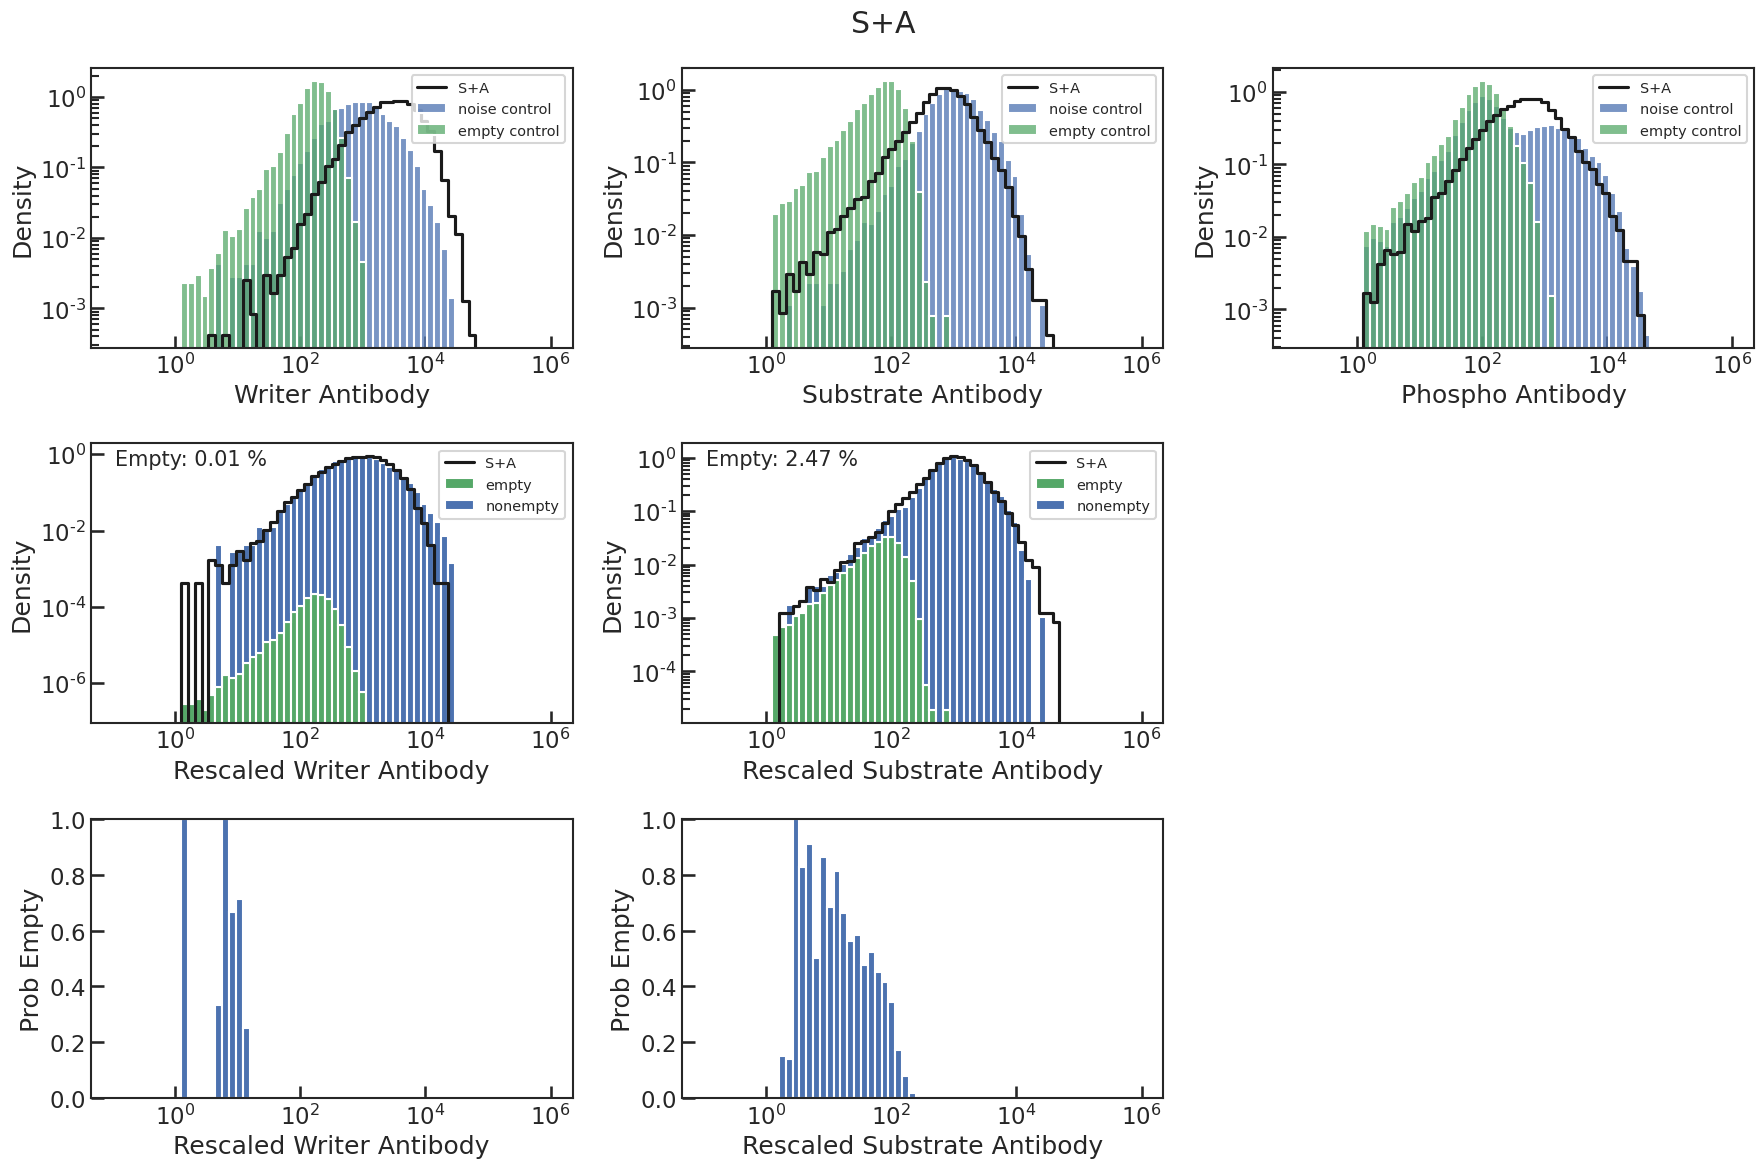

0.05715089092207093 [0.         0.14205882] 0
0.05423390939327466 [0.01662955 0.15868837] 0
0.05147869521884196 [0.00623936 0.15868837] 0
0.03578171878849912 [0.00623936 0.19372295] 0
0.028123218445391507 [0.00623936 0.21393332] 0
0.02790099225556064 [0.00623936 0.21243507] 0
0.027557875250231872 [0.04343316 0.24603618] 0
0.026149178552437674 [0.04343316 0.24922091] 0
0.02592819318372247 [0.04322548 0.24922091] 0
0.025928193183722442 [0.04322548 0.24934064] 0
0.025698995310667716 [0.03762003 0.24934064] 0
0.024557724547391135 [0.03762003 0.2387644 ] 0
0.02407367378334238 [0.03762003 0.23987304] 0
0.02280734670124096 [0.03299147 0.23987304] 0
0.02270074825757784 [0.03299147 0.24011751] 0
0.022661925285782702 [0.0328082  0.24011751] 0
0.022643316046697004 [0.03272037 0.24011751] 0
0.022591591860370352 [0.03243942 0.24011751] 0
0.02255339377390919 [0.03100476 0.238128  ] 0
0.022489992786273394 [0.03653672 0.24258283] 0
0.02245208807447041 [0.03635671 0.24258283] 0
     fun: 0.022452088074

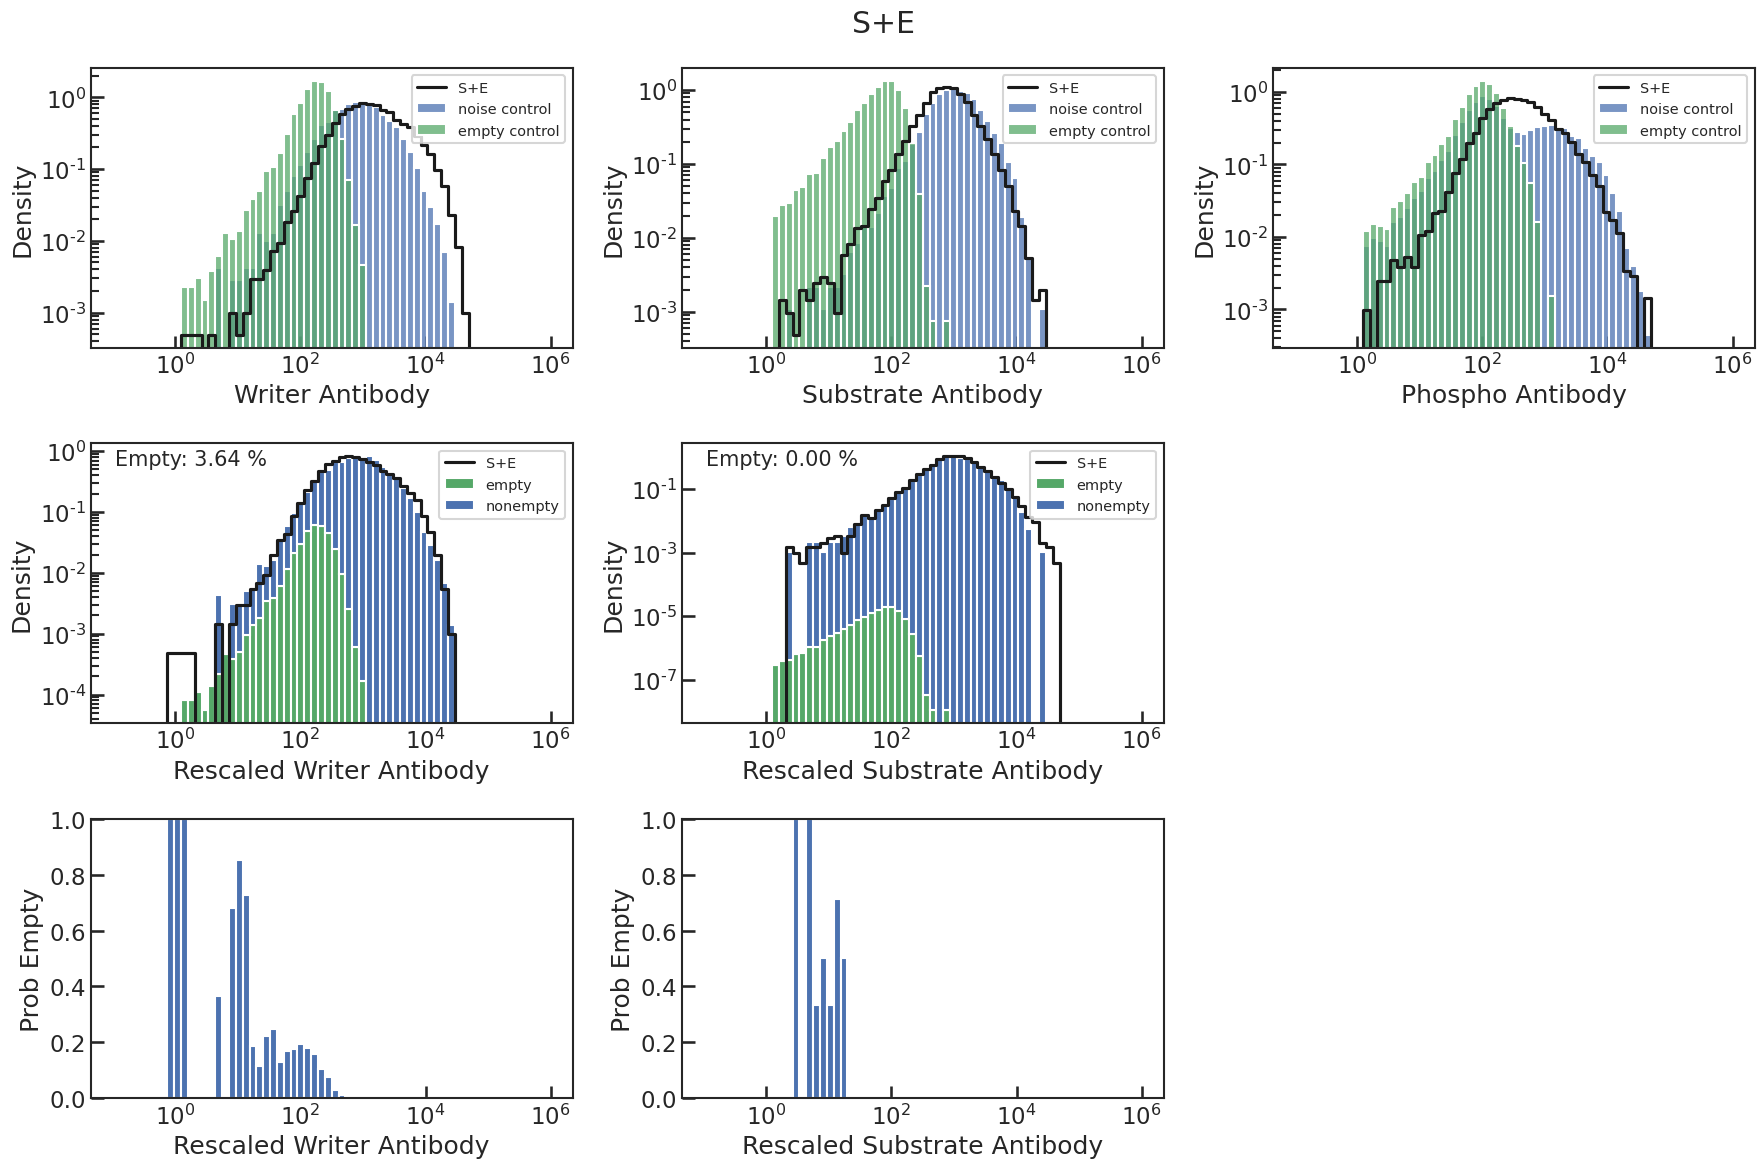

In [278]:
binrange = (-1, 6)

for dataset, group in df.groupby("dataset"):
    
    fig = plt.figure(figsize=(18, 12))
    
    fig.suptitle(dataset)
    
    ax = fig.add_subplot(3, 3, 1)
    
    sns.histplot(group['WT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(writer_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_writer_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')
        
    ax.set_xlabel("Writer Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    ################################################################
    
    
    (writer_empty_frac, writer_anti_scale) = noise.calc_mixture(group['WT_anti_exp'], 
                                                                empty_writer_noise, writer_noise)

        
    df.loc[group.index, 'WT_anti_rescaled'] = group['WT_anti_exp'] / 10**writer_anti_scale
        
        
    ax = fig.add_subplot(3, 3, 4, sharex=ax)
            
    
    
    sns.histplot(df.loc[group.index, 'WT_anti_rescaled'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    
    
    nonempty_hist, edges = np.histogram(np.log10(writer_noise.get_anti()), range=binrange, bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_writer_noise.get_anti()), range=binrange, bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([10**edges[:-1], 10**edges[:-1]], 10**edges, 
            weights=[empty_hist/empty_norm*writer_empty_frac, nonempty_hist/nonempty_norm*(1-writer_empty_frac)], 
            histtype='barstacked', color=['g', 'b'], label=['empty', 'nonempty'])
    
        
    ax.set_xlabel("Rescaled Writer Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    ax.text(0.05, 0.98, "Empty: {0:.2f} %".format(100*writer_empty_frac), transform=ax.transAxes,
           va='top', ha='left', fontsize='small')
    
    
    
    ################################################################
    
    df.loc[group.index, 'WT_prob_empty'] = noise.calc_prob_empty(df.loc[group.index, 'WT_anti_rescaled'], 
                                                                 writer_empty_frac, 
                                                                 empty_writer_noise, writer_noise)
    
    ax = fig.add_subplot(3, 3, 7, sharex=ax)
    
    df_tmp = group.copy()
    df_tmp['bin'] = pd.cut(df.loc[group.index, 'WT_anti_rescaled'], 10**edges, labels=False)
    df_tmp['prob_empty'] = df.loc[group.index, 'WT_prob_empty']    
    
    hist_corr = df_tmp.groupby(['bin'])['prob_empty'].mean().to_frame("mean")
    
    hist_corr =  hist_corr.reindex(pd.Index(np.arange(len(edges)-1), name='bin', fill_value=np.nan))['mean'].values
    hist_corr = np.nan_to_num(hist_corr)

    ax.hist(10**edges[:-1], 10**edges, weights=hist_corr, histtype='bar', color='b')
    
    ax.set_ylim(0, 1)
    
    ax.set_xlabel("Rescaled Writer Antibody")
    ax.set_ylabel("Prob Empty")
    
    
    ################################################################
    
    
    
    ax = fig.add_subplot(3, 3, 2)
        
    sns.histplot(group['ST_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(substrate_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_substrate_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Substrate Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    
    ################################################################
    
    (substrate_empty_frac, substrate_anti_scale) = noise.calc_mixture(group['ST_anti_exp'], 
                                                                empty_substrate_noise, substrate_noise)

        
    ax = fig.add_subplot(3, 3, 5, sharex=ax)
            
    df.loc[group.index, 'ST_anti_rescaled'] = group['ST_anti_exp'] / 10**substrate_anti_scale
    
    sns.histplot(df.loc[group.index, 'ST_anti_rescaled'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    
    
    nonempty_hist, edges = np.histogram(np.log10(substrate_noise.get_anti()), range=binrange, bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_substrate_noise.get_anti()), range=binrange, bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([10**edges[:-1], 10**edges[:-1]], 10**edges, 
            weights=[empty_hist/empty_norm*substrate_empty_frac, nonempty_hist/nonempty_norm*(1-substrate_empty_frac)], 
            histtype='barstacked', color=['g', 'b'], label=['empty', 'nonempty'])
    
        
    ax.set_xlabel("Rescaled Substrate Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
      
    ax.text(0.05, 0.98, "Empty: {0:.2f} %".format(100*substrate_empty_frac), transform=ax.transAxes,
           va='top', ha='left', fontsize='small')
    
    
    ################################################################
    
    df.loc[group.index, 'ST_prob_empty'] = noise.calc_prob_empty(df.loc[group.index, 'ST_anti_rescaled'], 
                                                                 substrate_empty_frac, 
                                                                 empty_substrate_noise, substrate_noise)
    
    ax = fig.add_subplot(3, 3, 8, sharex=ax)
    
    df_tmp = group.copy()
    df_tmp['bin'] = pd.cut(df.loc[group.index, 'ST_anti_rescaled'], 10**edges, labels=False)
    df_tmp['prob_empty'] = df.loc[group.index, 'ST_prob_empty']    
    
    hist_corr = df_tmp.groupby(['bin'])['prob_empty'].mean().to_frame("mean")
    
    hist_corr =  hist_corr.reindex(pd.Index(np.arange(len(edges)-1), name='bin', fill_value=np.nan))['mean'].values
    hist_corr = np.nan_to_num(hist_corr)

    ax.hist(10**edges[:-1], 10**edges, weights=hist_corr, histtype='bar', color='b')
    
    ax.set_ylim(0, 1)
    
    ax.set_xlabel("Rescaled Substrate Antibody")
    ax.set_ylabel("Prob Empty")
    
    
    ################################################################
    
    ax = fig.add_subplot(3, 3, 3)
    
    sns.histplot(group['SpT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    ax.set_yscale('log')
        
    plt.tight_layout()
    
    plt.show()


In [279]:

zero = 1e-8

for dataset, group in df.groupby("dataset"):
    
    
    
    # convert antibody measurements to GFP measurements
#     df.loc[group.index, 'WT_GFP_infer'] = writer_noise.anti_to_GFP_median(df.loc[group.index, 'WT_anti_rescaled'])
    df.loc[group.index, 'WT_GFP_infer'] = writer_noise.anti_to_GFP(df.loc[group.index, 'WT_anti_rescaled'])
    df.loc[group.index, 'WT_conc_infer'] = np.maximum(df.loc[group.index, 'WT_GFP_infer'] - 10**np.mean(np.log10(empty_writer_noise.get_GFP())), zero)

        
#     df.loc[group.index, 'ST_GFP_infer'] = substrate_noise.anti_to_GFP_median(df.loc[group.index, 'ST_anti_rescaled'])
    df.loc[group.index, 'ST_GFP_infer'] = substrate_noise.anti_to_GFP(df.loc[group.index, 'ST_anti_rescaled'])
    df.loc[group.index, 'ST_conc_infer'] = np.maximum(df.loc[group.index, 'ST_GFP_infer'] - 10**np.mean(np.log10(empty_substrate_noise.get_GFP())), zero)

    
#     df.loc[group.index, 'SpT_GFP_infer'] = phospho_noise.anti_to_GFP_median(df.loc[group.index, 'SpT_anti_exp'])
    df.loc[group.index, 'SpT_GFP_infer'] = phospho_noise.anti_to_GFP(df.loc[group.index, 'SpT_anti_exp'])
    df.loc[group.index, 'SpT_conc_infer'] = np.maximum(df.loc[group.index, 'SpT_GFP_infer'] - 10**np.mean(np.log10(empty_phospho_noise.get_GFP())), zero)

    df.loc[group.index, 'Sp_frac_GFP_infer'] = df.loc[group.index, 'SpT_GFP_infer'] / df.loc[group.index, 'ST_GFP_infer']
    df.loc[group.index, 'Sp_frac_conc_infer'] = df.loc[group.index, 'SpT_conc_infer'] / df.loc[group.index, 'ST_conc_infer']
    
    
    df.loc[group.index, 'total_prob_empty'] = 1.0 - (1-df.loc[group.index, 'ST_prob_empty'])*(1-df.loc[group.index, 'WT_prob_empty'])
    
    

print(len(df))
print(len(df.dropna()))



96261
95852


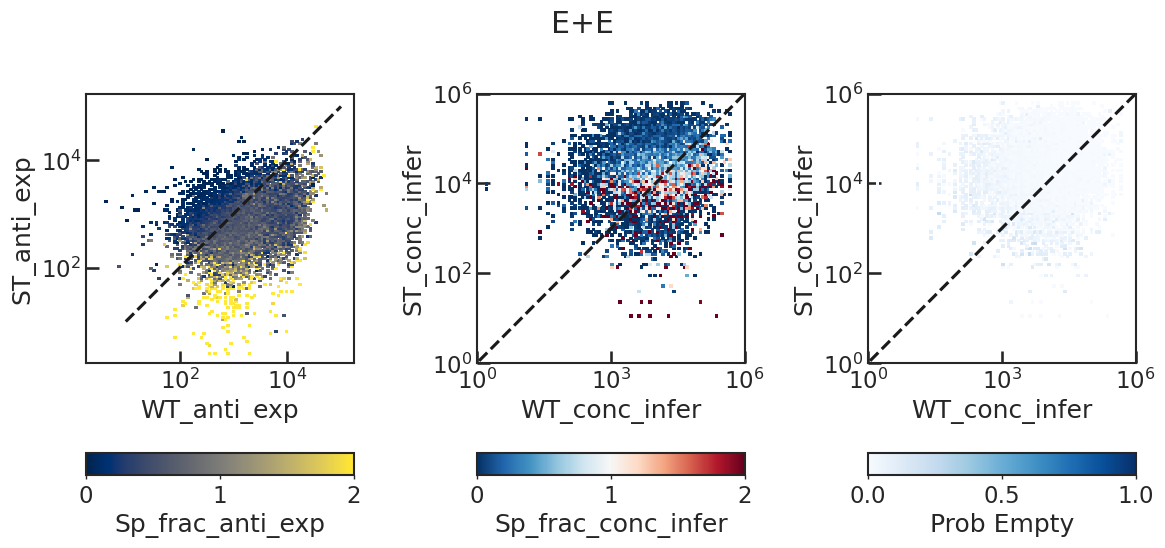

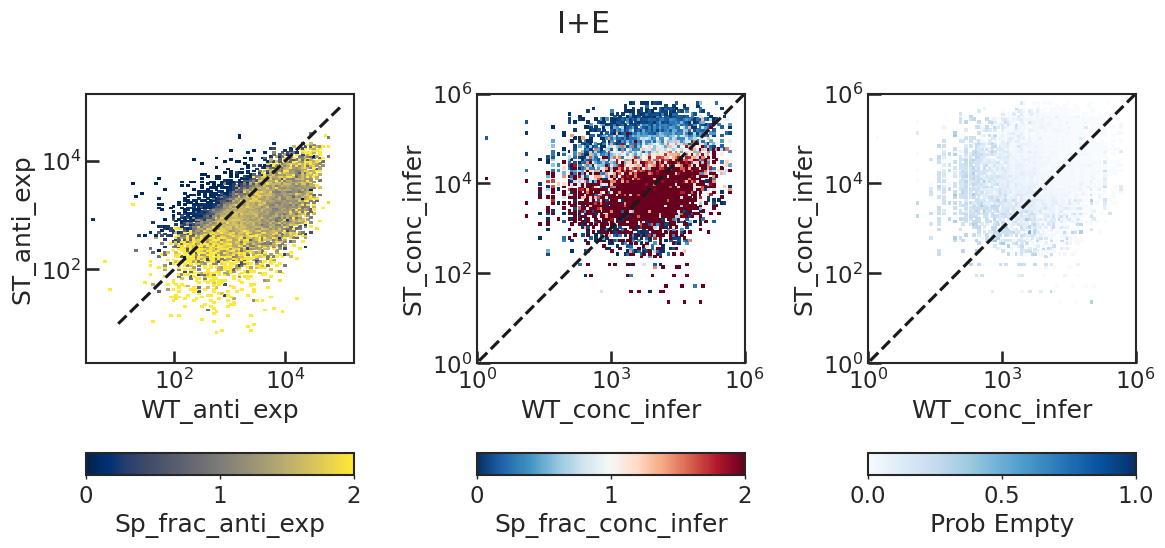

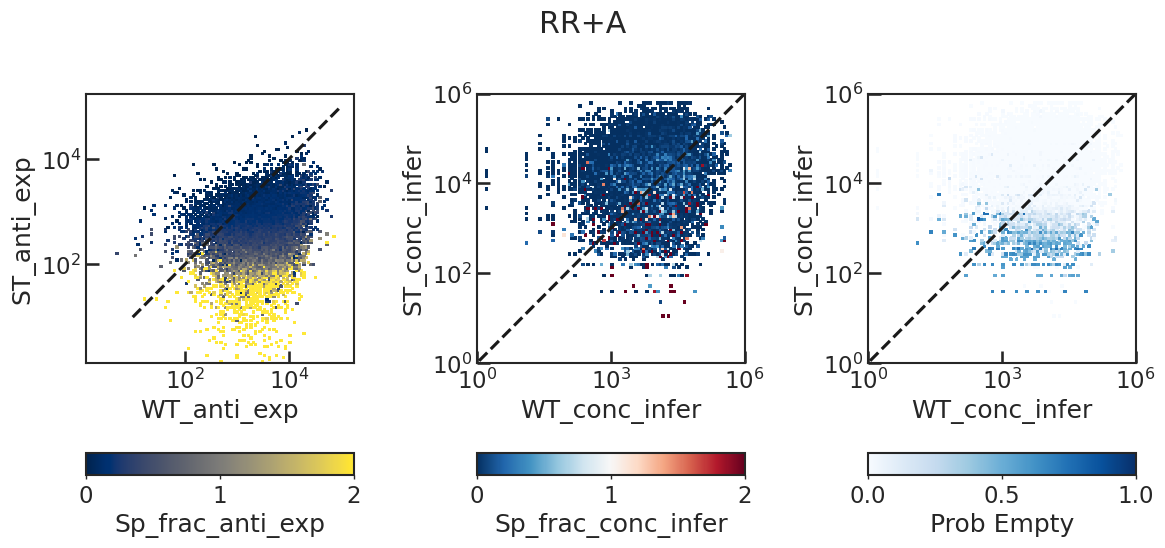

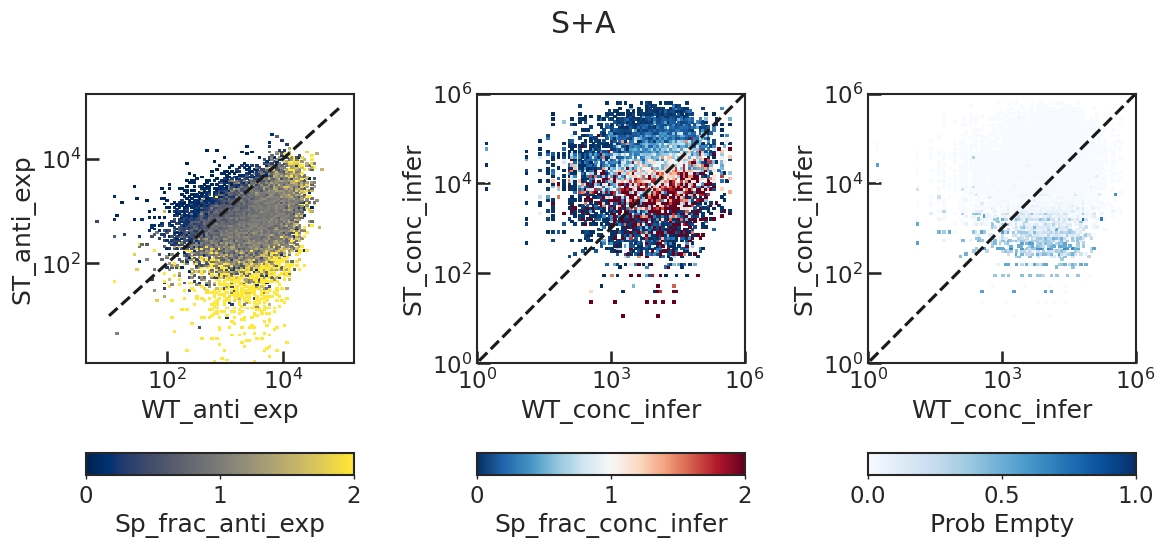

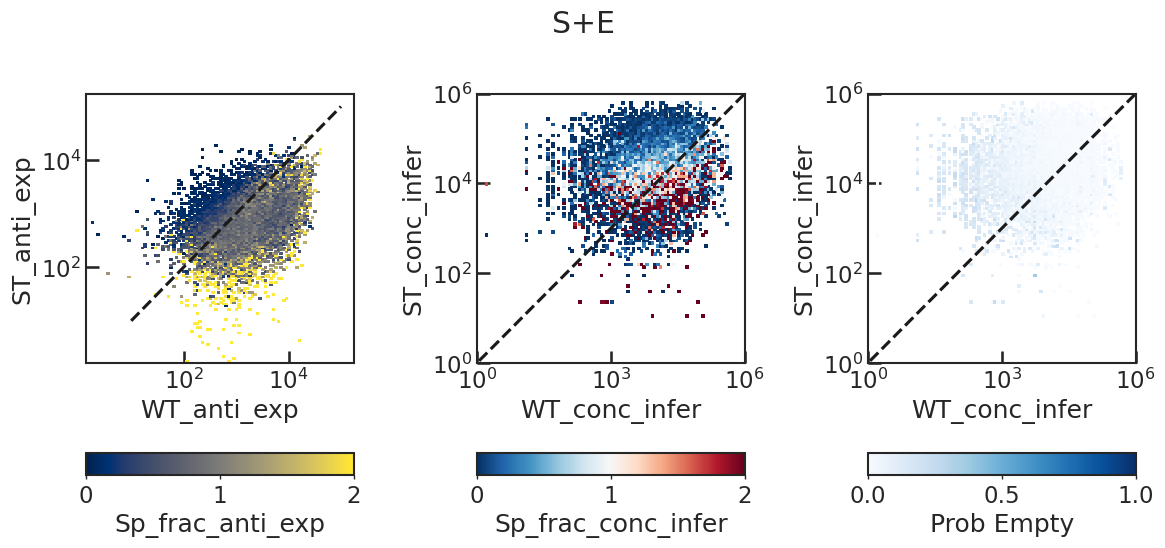

In [280]:



for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))
    
    ax = axes[0]
    
    df_tmp = group.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm1 = mpl.colors.Normalize(vmin=0, vmax=2.0)
    cmap1=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap1, norm=norm1, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
    
    
    ax = axes[1]
    
    df_tmp = group.copy().dropna()
        
    hist, xedges = np.histogram(np.log10(df_tmp['WT_conc_infer']), bins=100, range=(0, 6))
    hist, yedges = np.histogram(np.log10(df_tmp['ST_conc_infer']), bins=100, range=(0, 6))
    xedges = 10**xedges
    yedges = 10**yedges

#     xedges = writer_bins
#     yedges = substrate_bins

    df_tmp['xbin'] = pd.cut(df_tmp['WT_conc_infer'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_conc_infer'], yedges, labels=False)
    

    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_conc_infer'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm2 = mpl.colors.Normalize(vmin=0, vmax=2.0)
    cmap2=plt.cm.RdBu_r
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap2, norm=norm2, rasterized=True)
    
    t = np.linspace(1e-1, 1e6)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
    
    
    
    ax = axes[2]
    
 
    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['total_prob_empty'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm3 = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap3=plt.cm.Blues
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap3, norm=norm3, rasterized=True)
    
    t = np.linspace(1e-1, 1e6)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
    
    

    fig.suptitle(construct)
    
    
    plt.tight_layout()
    
    
    
    bbox = axes[0].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap1, norm=norm1, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")
    
    
    bbox = axes[1].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap2, norm=norm2, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_conc_infer")
    
    
    bbox = axes[2].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap3, norm=norm3, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Prob Empty")
    
    

    plt.show()
    

In [281]:
def solve(df_data, df_info, param_dict, x0, bounds, verbose=False):
    
    df_copy = df.dropna().copy()
    
    if verbose:
        start = time.time()

    loss_dict = {}
    def func(x):
                        
        loss = 0.0
        
        
        
        for index, row in df_info.iterrows():
            dataset = row['dataset']
            
            construct = row['construct']
            
            model_params = 10**np.array(x)[param_dict[construct][0:]]
                
            df_data = df_copy.query("dataset=='{}'".format(dataset))
            
#            
            if row['model'] == 'push':
                            
            
                df_copy.loc[df_data.index, 'SpT_conc_predict'] = pp.PushAmp().predict_all(df_data[['WT_conc_infer', 'ST_conc_infer']].values, model_params)[:, 0]
            
                       
            df_copy.loc[df_data.index, 'SpT_GFP_predict'] = df_copy.loc[df_data.index, 'SpT_conc_predict'] + 10**np.mean(np.log10(empty_phospho_noise.get_GFP()))
            
            loss_dict[dataset] = np.mean((np.log10(df_copy.loc[df_data.index, 'SpT_GFP_predict'])-np.log10(df_copy.loc[df_data.index, 'SpT_GFP_infer']))**2)
            
            prob_empty = df_copy.loc[df_data.index, 'total_prob_empty']  
            
            loss += np.mean((1-prob_empty)*(np.log10(df_copy.loc[df_data.index, 'SpT_GFP_predict'])-np.log10(df_copy.loc[df_data.index, 'SpT_GFP_infer']))**2)
            
            
        loss += 1e-6*np.sum((x-np.array(x0))**2)
        return loss




    print("Initial Loss:", func(x0))

    def callback(x):
        print(func(x), 1e-6*np.sum((x-np.array(x0))**2), x)
#         print(loss_dict)

    res = opt.minimize(func, x0, method='L-BFGS-B', 
                       jac='2-point', bounds=bounds, 
                       options={'iprint':101, 'eps': 1e-6, 
                                'gtol': 1e-6, 'ftol':1e-6},
                      callback=callback)
    

    print("Final Loss:", res.fun, func(res.x))

    end = time.time()

    print("Time Elapsed", end-start, "seconds")

    print(res)
        
    
    return res

In [282]:
param_dict = {}

param_labels = [r"$\log_{10}(v_{bg}^p)$", r"$\log_{10}(v_{WS}^p)$"]
x0 = [-1.0, 0.0]
bounds = [(None, None), (None, None)]
# bounds = [(-3, 1), (-3, 3)]

param_index = 1
for index, row in df_info.iterrows():
    
    construct = row['construct']
    model = row['model']
                
    if construct not in param_dict:
        if model == 'background':
            param_dict[construct] = [0]

        elif model == 'push':
            param_dict[construct] = [0, 1, param_index+1]
            param_index += 1
            
            param_labels.append(construct + ": " + r"$\log_{10}(\alpha_{WS})$")
            x0.append(4.0)
            bounds.append((None, None))
        

print(param_labels)
print(param_dict)

print(x0)
print(bounds)

res = solve(df, df_info, param_dict, x0, bounds, verbose=True)


['$\\log_{10}(v_{bg}^p)$', '$\\log_{10}(v_{WS}^p)$', 'E+E: $\\log_{10}(\\alpha_{WS})$', 'I+E: $\\log_{10}(\\alpha_{WS})$', 'RR+A: $\\log_{10}(\\alpha_{WS})$', 'S+A: $\\log_{10}(\\alpha_{WS})$', 'S+E: $\\log_{10}(\\alpha_{WS})$']
{'E+E': [0, 1, 2], 'I+E': [0, 1, 3], 'RR+A': [0, 1, 4], 'S+A': [0, 1, 5], 'S+E': [0, 1, 6]}
[-1.0, 0.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
Initial Loss: 7.953298735546717
6.649151251555613 9.999999999999997e-07 [-1.56127328 -0.81070836  4.06262927  3.94880979  4.13876842  4.01981487
  4.03914197]
6.582799659587227 9.015277505294937e-07 [-1.55781958 -0.71954539  4.06963456  3.86645543  4.22164634  3.98945141
  4.02641971]
6.35913722571082 3.7586035062261033e-06 [-1.80845264  0.03778658  4.18186048  2.88421641  5.29768809  3.63944176
  3.89258896]
5.928352932242126 4.6887461606119e-06 [-1.8340617  -0.12272323  4.21898479  2.77180276  5.50137911  3.60591523
  3.8897212 ]
5.263

[2.75340983e-03 3.86488042e+00 1.10288255e+06]


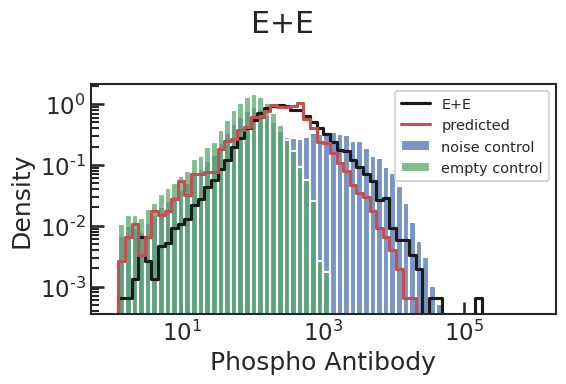

[2.75340983e-03 3.86488042e+00 5.15277561e-01]


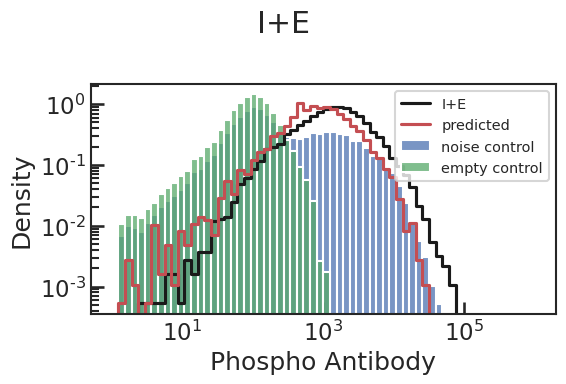

[2.75340983e-03 3.86488042e+00 1.10937459e+10]


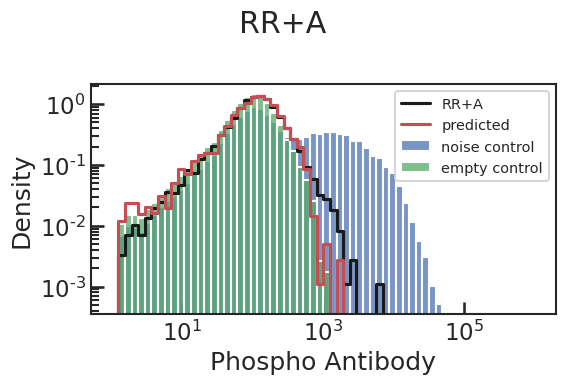

[2.75340983e-03 3.86488042e+00 1.45446793e+05]


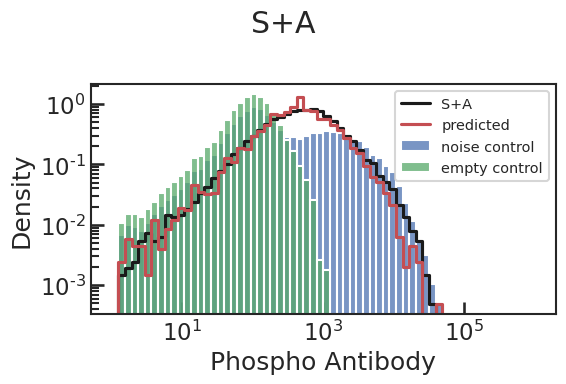

[2.75340983e-03 3.86488042e+00 4.05872068e+05]


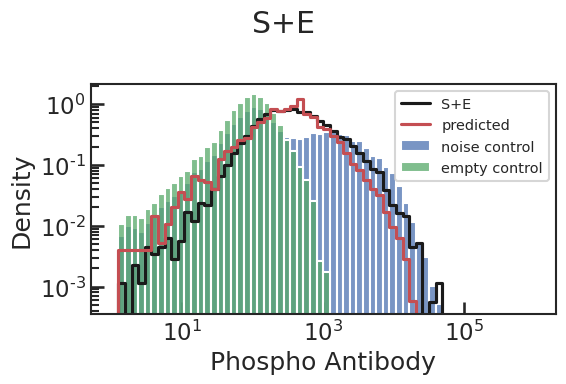

In [283]:
binrange = (0, 6)

for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    model_params = 10**res.x[param_dict[construct][0:]]
    
    print(model_params)
    
    df.loc[group.index, 'SpT_conc_predict'] = pp.PushAmp().predict_all(group[['WT_conc_infer', 'ST_conc_infer']].values, model_params)[:, 0]
    df.loc[group.index, 'SpT_GFP_predict'] = df.loc[group.index, 'SpT_conc_predict'] + 10**np.mean(np.log10(empty_phospho_noise.get_GFP()))
    
    df.loc[group.index, 'SpT_anti_predict'] = phospho_noise.GFP_to_anti(df.loc[group.index, 'SpT_GFP_predict'])
    
    
    df.loc[group.index, 'Sp_frac_conc_predict'] = df.loc[group.index, 'SpT_conc_predict'] / group['ST_conc_infer']
    
    
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    
    fig.suptitle(construct)

    
    ax = axes
    
    sns.histplot(df.loc[group.index, 'SpT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=construct, element='step', fill=False, color='k', stat='density')
    sns.histplot(df.loc[group.index, 'SpT_anti_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    ax.set_yscale('log')
        
    plt.tight_layout()
    
    plt.show()
    

[2.75340983e-03 3.86488042e+00 1.10288255e+06]


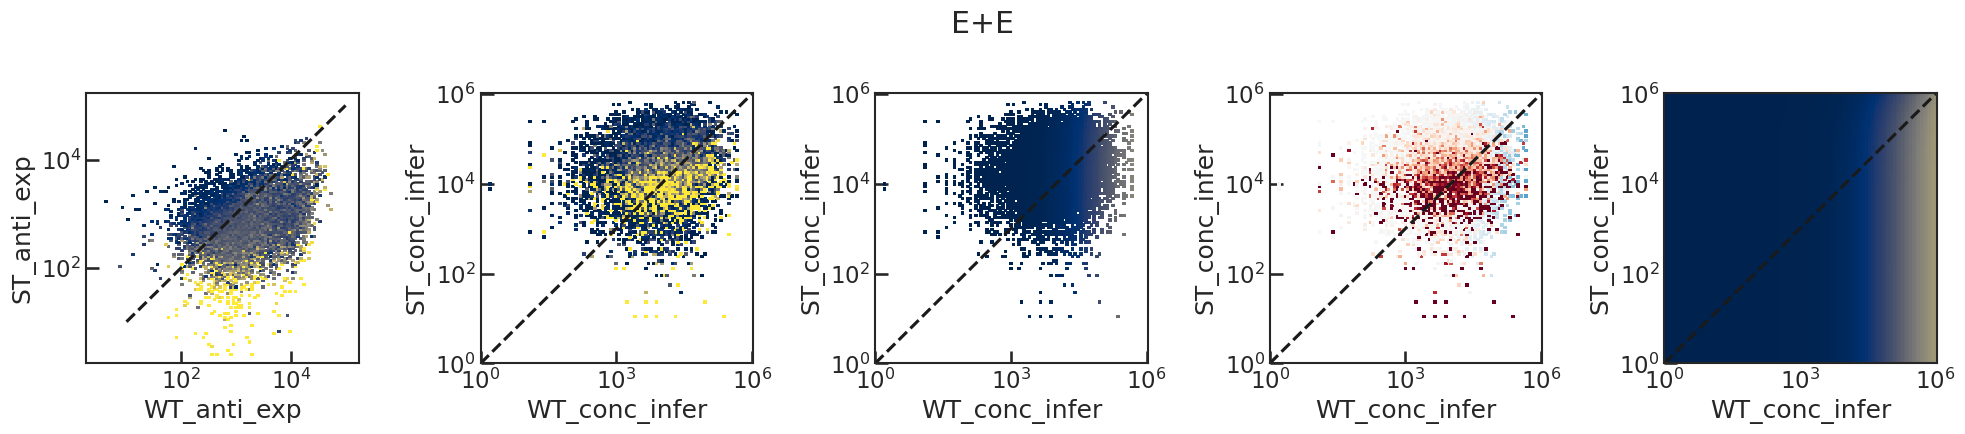

[2.75340983e-03 3.86488042e+00 5.15277561e-01]


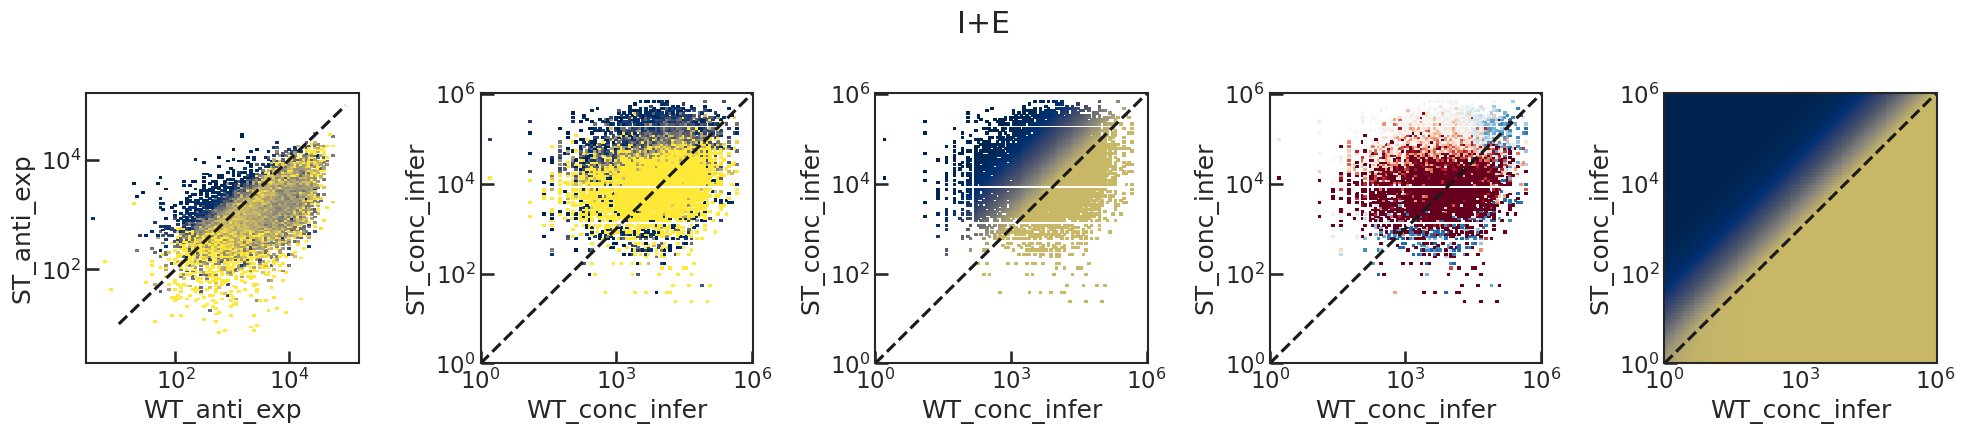

[2.75340983e-03 3.86488042e+00 1.10937459e+10]


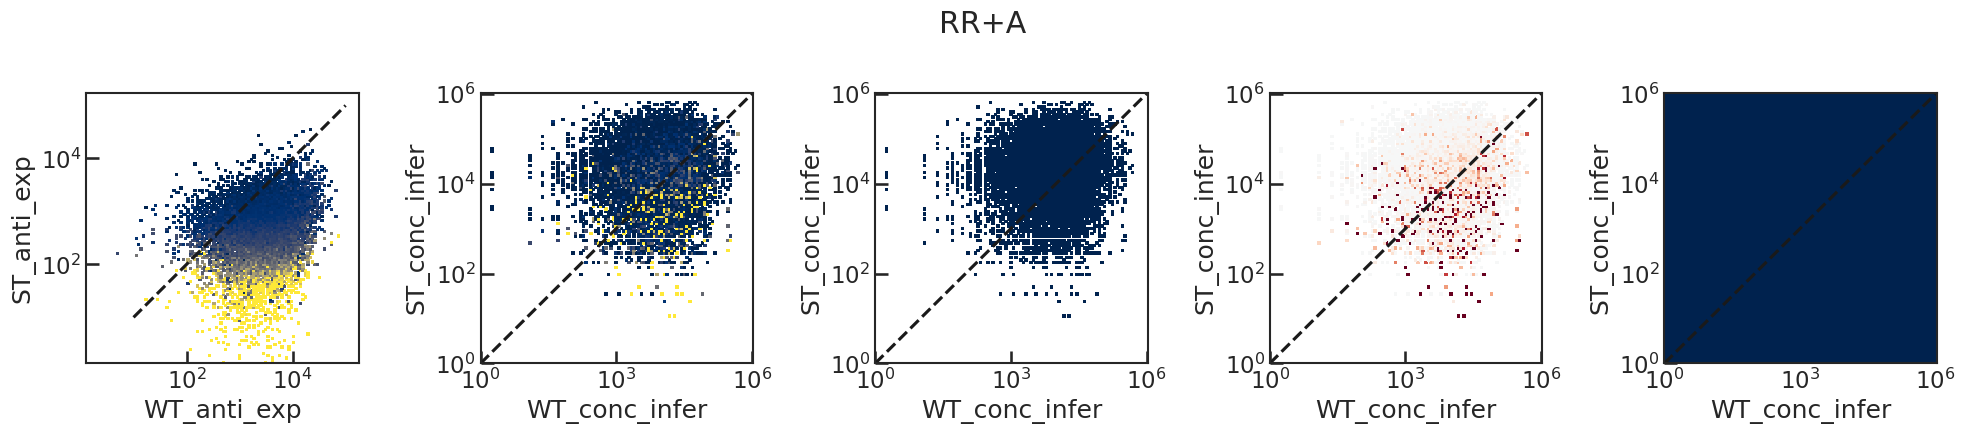

[2.75340983e-03 3.86488042e+00 1.45446793e+05]


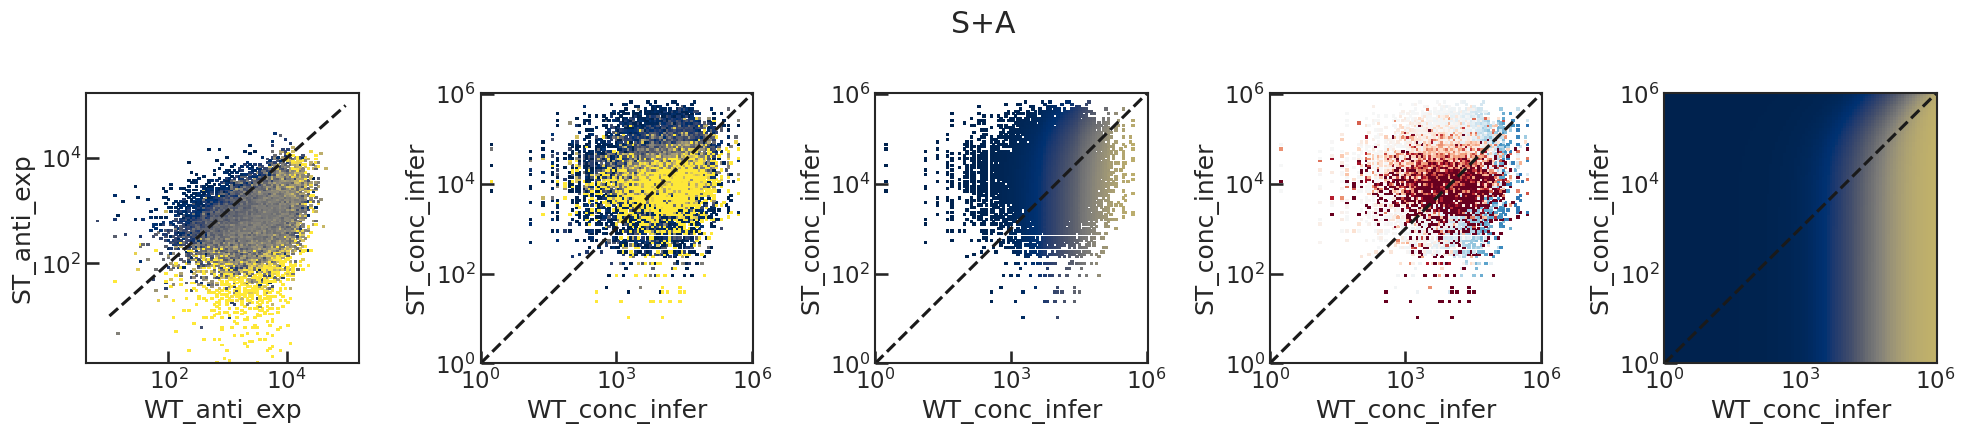

[2.75340983e-03 3.86488042e+00 4.05872068e+05]


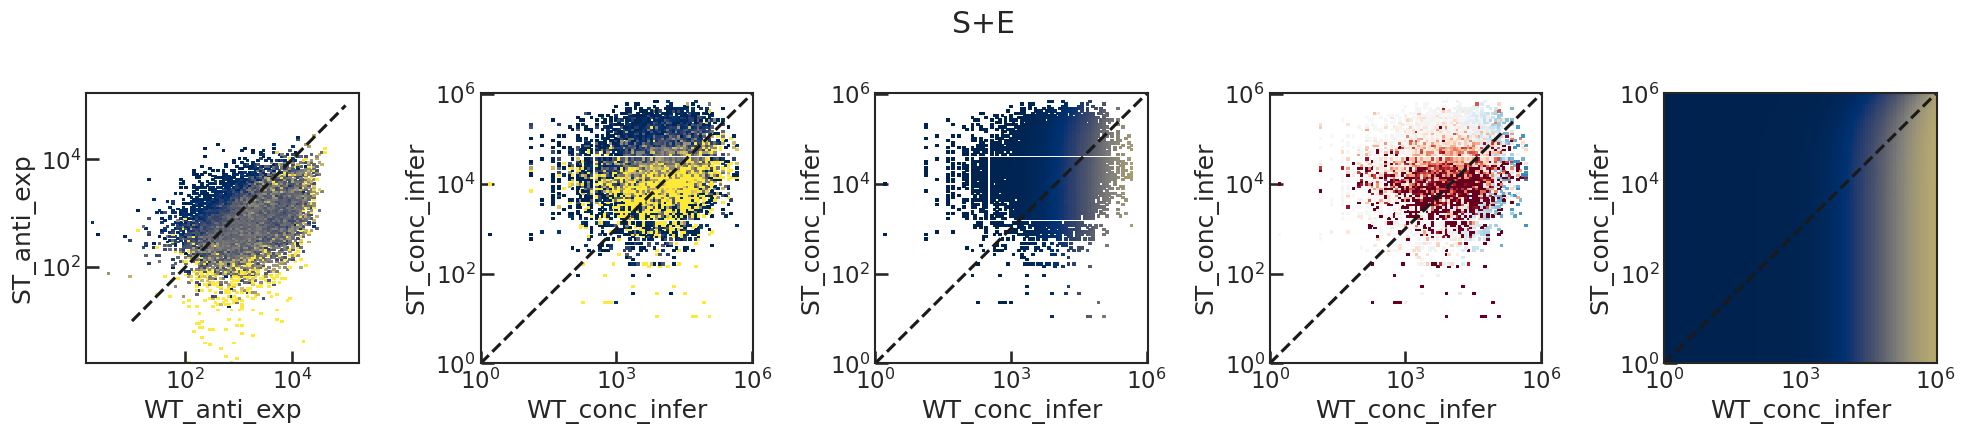

In [286]:



for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    
#     noise_params = res.x[param_dict[construct][0:1]]
    model_params = 10**res.x[param_dict[construct][0:]]
    print(model_params)

    
    fig = plt.figure(figsize=(20, 4.5))
    
    
    fig.suptitle(construct)
    
    ax = fig.add_subplot(1, 5, 1)
    
    df_tmp = group.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm1 = mpl.colors.Normalize(vmin=0, vmax=2.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm1, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
    
    
    
    
    
    
    ax = fig.add_subplot(1, 5, 2)
    
    df_tmp = group.copy().dropna()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_conc_infer']), bins='auto', range=(0, 6))
    hist, yedges = np.histogram(np.log10(df_tmp['ST_conc_infer']), bins='auto', range=(0, 6))
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_conc_infer'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_conc_infer'], yedges, labels=False)
    

    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_conc_infer'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm2 = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm2, rasterized=True)
    
    t = np.linspace(1e0, 1e6)
    ax.plot(t, t, 'k--')
    
#     ax.set_xlim(1e2, 1e6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
        
        
    
    
    
    
    ax = fig.add_subplot(1, 5, 3, sharex=ax, sharey=ax)
    
    df_tmp = group.copy().dropna()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_conc_infer']), bins='auto', range=(0, 6))
    hist, yedges = np.histogram(np.log10(df_tmp['ST_conc_infer']), bins='auto', range=(0, 6))
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_conc_infer'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_conc_infer'], yedges, labels=False)

    
    df_tmp['SpT_conc_predict'] = pp.PushAmp().predict_all(df_tmp[['WT_conc_infer', 'ST_conc_infer']].values, model_params)
    
    df_tmp['Sp_frac_predict'] = df_tmp['SpT_conc_predict'] / df_tmp['ST_conc_infer']

    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_predict'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm, rasterized=True)
    
    t = np.linspace(1e0, 1e6)
    ax.plot(t, t, 'k--')
    
#     ax.set_xlim(1e2, 1e6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
    
    
    
    
    
    ax = fig.add_subplot(1, 5, 4, sharex=ax, sharey=ax)
    
    df_tmp['error'] = df_tmp['Sp_frac_predict'] - df_tmp['Sp_frac_conc_infer']
    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['error'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm3 = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
    cmap3=plt.cm.RdBu
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap3, norm=norm3, rasterized=True)
    
    t = np.linspace(1e0, 1e6)
    ax.plot(t, t, 'k--')
    
#     ax.set_xlim(1e2, 1e6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
        
        
    
    
    
    
    ax = fig.add_subplot(1, 5, 5, sharex=ax, sharey=ax)
    
    X, Y = np.meshgrid(np.logspace(0, 6, 100, base=10), np.logspace(0, 6, 100, base=10))
    
    
    SpT_GFP_predict = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array(model_params))[:, 0]
    
    Sp_frac_GFP_predict = SpT_GFP_predict / Y.flatten()
    
#     norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    ax.pcolormesh(X, Y, Sp_frac_GFP_predict.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')
    
    t = np.linspace(1e0, 1e6)
    ax.plot(t, t, 'k--')
    
#     ax.set_xlim(1e2, 1e6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
        
    
    
    
        
    
    
    plt.tight_layout()
    
    
    
#     bbox = axes[0].get_position()
    
#     cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
#     cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm1, orientation='horizontal')

#     cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
#     cbar.set_label(r"Sp_frac_anti_exp")
    
    
#     bbox = axes[1].get_position()
    
#     cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
#     cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm2, orientation='horizontal')

#     cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
#     cbar.set_label(r"Sp_frac_conc_infer")
    
    
#     bbox = axes[2].get_position()
    
#     cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
#     cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

#     cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
#     cbar.set_label(r"Sp_frac_predict")
    
    
#     bbox = axes[3].get_position()
    
#     cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
#     cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap3, norm=norm3, orientation='horizontal')

#     cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
#     cbar.set_label(r"Error = Predicted - True")

    

    plt.show()
    

['I+E', 'S+A', 'S+E', 'E+E', 'RR+A']
[-0.2879587694994754, 5.162704148619933, 5.608389164362069, 6.042529267072775, 10.045078215737417]


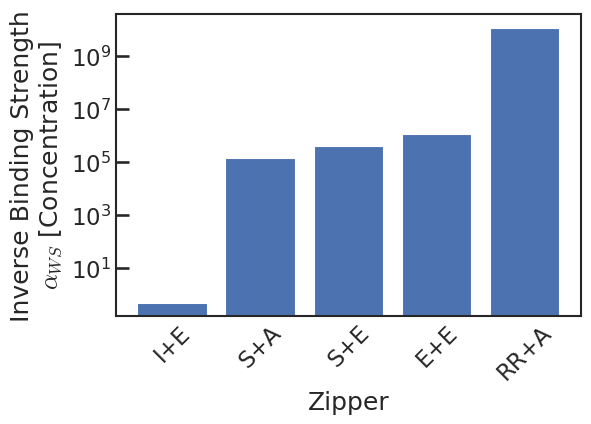

In [287]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

construct_list = list(param_dict.keys())

alphaWS_list = [res.x[param_dict[construct]][2] for construct in construct_list]

construct_list = [x for _, x in sorted(zip(alphaWS_list, construct_list))]
alphaWS_list = sorted(alphaWS_list)

print(construct_list)
print(alphaWS_list)

ax.bar(construct_list, 10**np.array(alphaWS_list))

ax.set_yscale('log')
ax.set_xlabel("Zipper")
ax.set_ylabel("Inverse Binding Strength\n" + r"$\alpha_{WS}$ [Concentration]")
plt.xticks(rotation=45)

plt.show()

[1.27701491e-03 2.74732114e-01 5.98123959e+06]


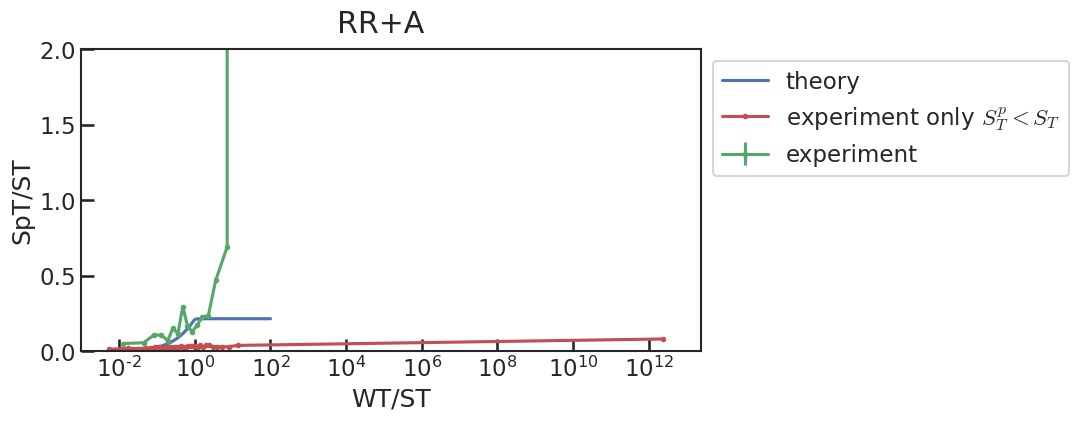

[1.27701491e-03 2.74732114e-01 9.43176791e+01]


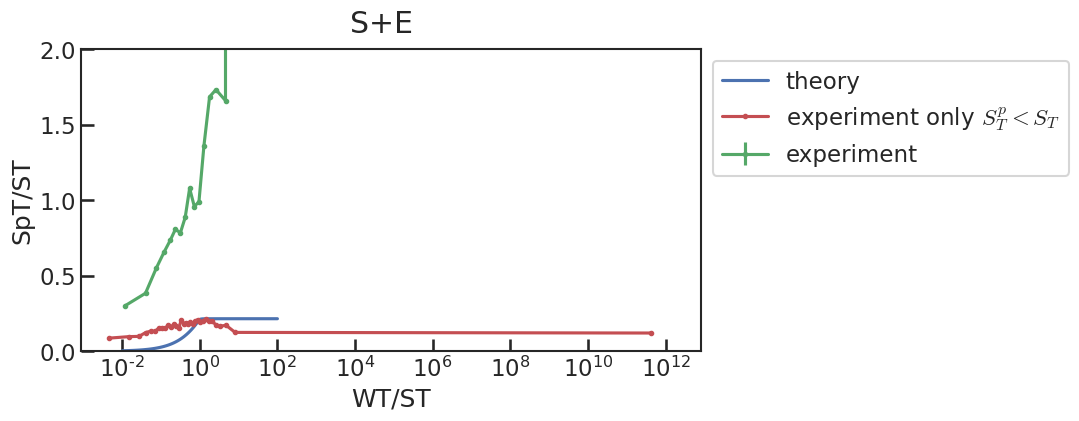

In [206]:
for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    
#     noise_params = res.x[param_dict[construct][0:1]]
    model_params = 10**res.x[param_dict[construct][0:]]
    
    print(model_params)

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    fig.suptitle(construct)
    
    ST = 1e3*model_params[2]*np.ones(100)
    WT = np.logspace(np.log10(1e3*model_params[2])-2, np.log10(1e3*model_params[2])+2, 100, base=10)
    
    SpT = pp.PushAmp().predict_all(np.asfortranarray(np.c_[WT, ST]), np.array(model_params))[:, 0]
    
    ax.plot(WT/ST, SpT/ST, 'b', label="theory")
    
    
    
    
#     df_tmp = group.query("SpT_conc <= ST_conc").copy().dropna()
    df_tmp = group.copy().dropna()
    df_tmp['ratio'] = df_tmp['WT_conc_infer'] / df_tmp['ST_conc_infer']
    
    bin_labels, edges = pd.qcut(df_tmp['ratio'], 16, labels=False, retbins=True)
    
    df_tmp['bin'] = bin_labels
    
    Sp_frac = df_tmp.groupby('bin')['Sp_frac_conc_infer'].mean() 
    Sp_frac_err = df_tmp.groupby('bin')['Sp_frac_conc_infer'].std()
    
    ax.errorbar((edges[1:]+edges[0:len(edges)-1])/2, Sp_frac, yerr=0, fmt='g.-', label="experiment", ms=6.0)
    
    
    
    df_tmp = group.query("SpT_conc_infer <= 1.0*ST_conc_infer").copy().dropna()
#     df_tmp = group.copy().dropna()
    df_tmp['ratio'] = df_tmp['WT_conc_infer'] / df_tmp['ST_conc_infer']
    
    bin_labels, edges = pd.qcut(df_tmp['ratio'], 32, labels=False, retbins=True)
    
    df_tmp['bin'] = bin_labels
    
    Sp_frac = df_tmp.groupby('bin')['Sp_frac_conc_infer'].mean() 
    
    ax.plot((edges[1:]+edges[0:len(edges)-1])/2, Sp_frac, 'r.-', label=r"experiment only $S^p_T < S_T$", ms=6.0)
    
    ax.set_xscale('log')
    
    ax.set_ylim(0, 2.0)
    
    ax.set_ylabel("SpT/ST")
    ax.set_xlabel("WT/ST")
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0, 0.0, 0.0))
    
    plt.show()